# DS4G: Environmental Insights Explorer
## Exploring alternatives for emissions factor calculations

## I - Introduction and overview of the notebook

### Goal

Develop a methodology to calculate an average historical emissions factor of electricity generated for a sub-national region, using remote sensing data and techniques.
(from competition overview)


### Emission factor

An emissions factor is a representative value that attempts to relate the quantity of a pollutant released to the atmosphere with an activity associated with the release of that pollutant. These factors are usually expressed as the weight of pollutant divided by a unit weight, volume, distance, or duration of the activity emitting the pollutant (e.g., kilograms of particulate emitted per megagram of coal burned). Such factors facilitate estimation of emissions from various sources of air pollution. In most cases, these factors are simply averages of all available data of acceptable quality, and are generally assumed to be representative of long-term averages for all facilities in the source category (i.e., a population average).

The general equation for emissions estimation is:

E = A x EF x (1-ER/100)

where:

    E = emissions;
    A = activity rate;
    EF = emission factor, and
    ER =overall emission reduction efficiency, %

from https://www.epa.gov/air-emissions-factors-and-quantification/basic-information-air-emissions-factors-and-quantification


Since with satellite data we have a way to estimate emissions, and the plant dataset highlights some electricity generation assessments, we can deem the emission factor in the following way :
$$EF \approx E/A$$

#### Let's have in mind some rough estimates of NOx emissions per primary fuel

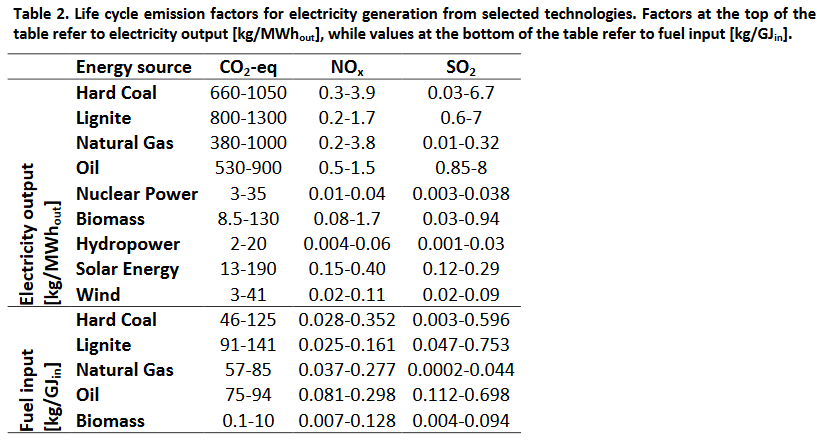

In [107]:
from IPython.display import Image
Image(filename='kaggle/input/external-data/emission_per_pf.png')

source : https://www.sciencedirect.com/science/article/abs/pii/S1364032113005534?via%3Dihub

Since we have access to NO2 satellite data - which can be linked to NOx emissions thanks to mass conversion regarding a chemical transformation - we are going to focus on some specific primary fuels to deem power plants emissions. 

To do so, one can notice that the main sources (among those used in Puerto Rico, see below please) of emissions per MWh of electricity produced are coal, gas, oil and solar. We will thus exclude hydropower and wind for a first approximation. Indeed the 10-100 factor between those two and the rest seems enough to discard them. This choice will be bolstered by the comparison of electricity generation below : coal, gas and oil account for the majority sources of electricity.

## Content of the rest of this notebook

## II - Data exploration : have a glimpse at power plants + correct Global Power Plant database which was inconsistent + complete with external data.
### A) A glimpse at initial data
### B) Modification of the GPPD and justification
#### a) Link between capacity and energy generation 
#### b) Add information from another dataset specific to US including Puerto Rico 

## III - First emission factor for the island : use clusters of plants that emit NOx and gaussian filters calibrated with satellite data (motivated by NO2 physical diffusion) to estimate the tropospheric emissions.
### A) NO2 data preprocessing
### B) Start with one cluster
### C) Try approach per cluster and sum to get a first estimation for the whole island


## IV -  Wind, temperature and humidity fields : create a dataset.
### A) Extract GFS data
### B) From 2D fields to 8 1D fields




## V -  Fitting : we physically and mathematically define, fit and use a model based on the dataset created in the fourth part of this notebook.

### A) Theory and mathematical form of the NO2 density
### B) Fitting implementation

## VI- Final results and critics.
### A) Results and answer to the competition
### B) Comments and perspectives

## General ideas of this submission :

To estimate emission factors (average, per month, marginal) we first preprocess data, modifying the power plants database with physics arguments and adding monthly information for some plants with an external dataset, and interpolating NO2 pictures in a certain limit of number of NAN values. This step is crucial to be able to estimate emission factors at a smaller slice than by year.

Then, a first "brutal" approach is taken: we group NO2-emitting plants in clusters regarding their locations (since some of them are close to each others) and we define a certain mask to locally extract NO2 above those clusters. At this step, we have merely mixed GPPD and S5P_NO2 datasets to provide an average historical emissions factor of electricity generated for a sub-national region, using remote sensing data and techniques. We discuss the limits of this first approach in the end of section III.

To improve those results, we totally change our approach: we merge NO2 pictures with the GFS dataset to get wind, temperature and humidity information. In addition, motivated by a physics background (Navier-Stokes framework and Fick's laws of diffusion among others), we create a new dataset which presents information in a different way: instead of working with 2D fields, we extract 1D density fields along discrete directions and in a certain perimeter for each cluster of plants and each accessible day. For each cluster, we then have per day 8 1D fields (one for each main discrete cardinal point) for temperature, humidity, wind and NO2. 

We then define an additve model for NO2 sources and diffusion and fit in the discrete direction that corresponds to the wind local direction (thus per cluster of power plants). Thanks to this model, we distinguish plant-related and background-related (nature, cities, airports) emissions per cluster of plants and per day. We believe this sharper focus is one way to deduce plant emissions from the total NO2 tropospheric field. 

We then display final results on emission factors and comments.

## II - Data exploration 

### A) A glimpse at initial data

In [109]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import folium
import os
import rasterio as rio
import numpy as np
import pandas as pd
import tifffile as tiff 
from datetime import datetime
import seaborn as sns
import matplotlib.cm as cm 
from folium import plugins 
from datetime import datetime
from matplotlib import ticker
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.optimize import curve_fit

In [110]:
### functions created by the Kaggle community
# Code source: https://www.kaggle.com/paultimothymooney/overview-of-the-eie-analytics-challenge     
def plot_points_on_map(dataframe, begin_index, end_index,
                       latitude_column, latitude_value, 
                       longitude_column, longitude_value, zoom):
    df = dataframe[begin_index:end_index]
    location = [latitude_value,longitude_value]
    plot = folium.Map(location=location,zoom_start=zoom)
    for i in range(0,len(df)):
        popup = folium.Popup(str(df.primary_fuel[i:i+1])+\
                             str(df.latitude[i:i+1])+str(df.longitude[i:i+1]))
        folium.Marker([df[latitude_column].iloc[i],
                       df[longitude_column].iloc[i]],popup=popup).add_to(plot)
    return plot

def overlay_image_on_puerto_rico(file_name,band_layer):
    band = rio.open(file_name).read(band_layer)
    m = folium.Map([lat, lon], zoom_start=8)
    folium.raster_layers.ImageOverlay(image=band,
                                      bounds=[[18.6,-67.3,],[17.9,-65.2]],
                                      colormap=lambda x: (1, 0, 0, x)).add_to(m)
    return m

def plot_scaled(file_name):
    vmin, vmax = np.nanpercentile(file_name, (5,95))  # 5-95% stretch
    img_plt = plt.imshow(file_name, cmap='gray', vmin=vmin, vmax=vmax)
    plt.show()

def split_column_into_new_columns(dataframe, column_to_split, new_column_one,
                                  begin_column_one, end_column_one):
    for i in range(0, len(dataframe)):
        dataframe.loc[i, new_column_one] = dataframe.loc[i, column_to_split][begin_column_one:end_column_one]
    return dataframe

#### Overview of the plants

In [111]:
power_plants = pd.read_csv('kaggle/input/ds4g-environmental-insights-explorer/eie_data/gppd/gppd_120_pr.csv')
power_plants = split_column_into_new_columns(power_plants,'.geo','latitude',50,66)
power_plants = split_column_into_new_columns(power_plants,'.geo','longitude',31,48)
power_plants['latitude'] = power_plants['latitude'].astype(float)
a = np.array(power_plants['latitude'].values.tolist()) # 18 instead of 8
power_plants['latitude'] = np.where(a < 10, a+10, a).tolist() 

lat=18.200178; lon=-66.664513
plot_points_on_map(power_plants,0,425,'latitude',lat,'longitude',lon,9)

#### Details on power plants

In [112]:
Capacity = power_plants["capacity_mw"]
Electricity_generation = power_plants["estimated_generation_gwh"]
Primary_fuels = power_plants["primary_fuel"]
for p_f in Primary_fuels.unique():
    E_g = Electricity_generation[Primary_fuels == p_f].sum()
    C_g = Capacity[Primary_fuels == p_f].sum()
    print("Capacity = {:.4f} MW, Electricity generation in GWh = {:.4f} for primary fuel : {}".format(C_g,E_g,p_f))

Capacity = 108.4000 MW, Electricity generation in GWh = 4953.1408 for primary fuel : Hydro
Capacity = 4201.5000 MW, Electricity generation in GWh = 23468.7308 for primary fuel : Oil
Capacity = 154.6500 MW, Electricity generation in GWh = 68.9627 for primary fuel : Solar
Capacity = 1105.0000 MW, Electricity generation in GWh = 7785.2435 for primary fuel : Gas
Capacity = 454.3000 MW, Electricity generation in GWh = 450562.6923 for primary fuel : Coal
Capacity = 124.6000 MW, Electricity generation in GWh = 22.1050 for primary fuel : Wind


Since electricity generation from solar primary fuel is more than 1000 times lower than from oil, coal and gas, we first focus only on the following primary fuels (for emissions estimations) : oil, coal and gaz.

With the example of oil, can we emphasize a link between the estimated generation of electricity and the capacity of each plant ?

In [113]:
Oil_capa = np.array(Capacity[Primary_fuels == 'Oil'])
Oil_gen = np.array(Electricity_generation[Primary_fuels == 'Oil'])
print(Oil_capa)
print(Oil_gen)

[1492.   990.   602.     6.   247.5  864. ]
[8334.0108118  5529.94014992 3362.650475     33.51478879 1382.48503748
 4826.12958539]


In [114]:
print(1000*Oil_gen/Oil_capa)

[5585.79813124 5585.79813124 5585.79813124 5585.79813124 5585.79813124
 5585.79813124]


We notice that the estimated electricity generation for those oil plants can be computed from the capacity, mutiplied by a constant factor (time unit).

We will be able to extend to smaller time slices with this assumption.

In [115]:
## We load the time per primary fuel to get estimated generation from capacity
Target_primary_fuels = ['Oil','Gas','Coal']
time_generation = []


for p_f in Target_primary_fuels:
    time_factor = np.array(1000*Electricity_generation[Primary_fuels == p_f])/np.array(Capacity[Primary_fuels == p_f])
    print('Time factor for {} = {}'.format(p_f, time_factor))
    time_generation.append(time_factor[0])

print(time_generation)

Time factor for Oil = [5585.79813124 5585.79813124 5585.79813124 5585.79813124 5585.79813124
 5585.79813124]
Time factor for Gas = [7045.46918897 7045.46918897 7045.46918897 7045.46918897 7045.46918897
 7045.46918897 7045.46918897 7045.46918897 7045.46918897]
Time factor for Coal = [991773.5074976]
[5585.798131236139, 7045.46918896545, 991773.5074976034]


#### Let's go into details for the coal plant : is data consistent ?

It seems there is an issue of consistency between capacity and estimated electricity generation. Regarding data from other sources, we can rely on capacity of the previous dataset more than on estimation. https://www.carbonbrief.org/mapped-worlds-coal-power-plants

This link between capacity and generation is described in https://www.eia.gov/tools/faqs/faq.php?id=101&t=3

### B) Modification of the GPPD and justification

#### a) Link between capacity and energy generation 

Let's start with a physics assessment on thermodynamic systems and heat engines:

$$ \forall i,T \in (I 	\times \mathbb R), Cmax_i*T = \int_{0}^{T}Cmax_idt\geq \int_{0}^{T} C_i(t)dt = G_{T,i} $$ 

Where
- $I$ is a set of indexes of plants : each index corresponds to a plant 
- $T$ is a time duration : a period during which we assess the production of a plant.
- $Cmax_i$ is the maximum capacity (a constant) of the plant indexed by i (capacity_MW in our dataset) (measure : power).
- $C_i(t)$ is the instantaneous capacity of the plant indexed by i at time t. It encapsulates to which extent the plant is running to produce electricity. If it is off, the value is 0 W. (measure : power).
- $G_{T,i}$ is the estimated generation of the plant indexed by i during the time duration T (estimated_generation_GWh in our dataset) (measure : energy).

NB : The time origin is translated to zero in the formula above to reduce writing, but the wear on plants and conditions may influence the instantaneous capacity.

#### Consequences on our dataset

The idea here is to check whether the inequality above is respected for every plant in our Global Power Plant database :

capacity_mw.T >= estimated_generation_gwh*1000, where T is one year in our case.

In [116]:
max_energy = power_plants["capacity_mw"]*24*365
estimated_energy = power_plants["estimated_generation_gwh"]*1000

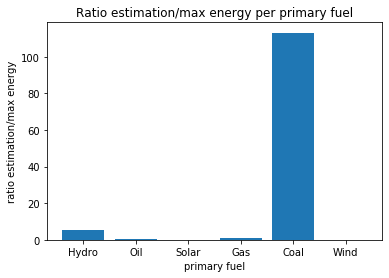

In [117]:
plt.bar(power_plants["primary_fuel"],estimated_energy/max_energy)
plt.title("Ratio estimation/max energy per primary fuel")
plt.xlabel("primary fuel")
plt.ylabel("ratio estimation/max energy")
plt.show()

As you can see some plants have a ratio greater than one, which means data is not consistent.
We are going to fix values for those having this ratio greater than one.

- According to https://www.statista.com/statistics/744947/capacity-factor-of-coal-power-plants-in-the-us-by-unit-type/ we must set a capacity factor (the estimation/max ratio) of $\textbf{0.54}$ for coal plants in 2018 in the US.
- According to https://www.sciencedirect.com/topics/engineering/capacity-factor we must set a capacity factor (the estimation/max ratio) of $\textbf{0.32}$ for hydro plants.

In [118]:
power_plants["estimated_generation_gwh"][power_plants["primary_fuel"] == "Hydro"] = 0.32*power_plants["capacity_mw"][power_plants["primary_fuel"] == "Hydro"]*24*365/1000
power_plants["estimated_generation_gwh"][power_plants["primary_fuel"] == "Coal"] = 0.54*power_plants["capacity_mw"][power_plants["primary_fuel"] == "Coal"]*24*365/1000

C:\Users\Louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Let's check again:

In [119]:
max_energy = power_plants["capacity_mw"]*24*365
estimated_energy = power_plants["estimated_generation_gwh"]*1000

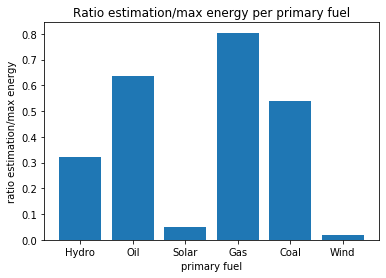

In [120]:
plt.bar(power_plants["primary_fuel"],estimated_energy/max_energy)
plt.title("Ratio estimation/max energy per primary fuel")
plt.xlabel("primary fuel")
plt.ylabel("ratio estimation/max energy")
plt.show()

NB: One can notice that the ratios for Gas and Oil are greater than in literature. Nonetheless we will keep them as such for the moment since we would need a dataset specific to Puerto Rico plants to adjust precisely. The goal here was first to avoid highly inconsistent data. We thus export:

#### b) Add information from another dataset specific to US including Puerto Rico 

Inspired by the valuable notebook : https://www.kaggle.com/ajulian/eia-923-input-nox-emissions-and-ef-reference we are going to complete our power plant dataset with month slices and information on energy generation and emissions.

In [121]:
add_data = pd.read_csv('kaggle/input/external-data/gppd_120_pr_ef.csv')   #additional dataset

In [122]:
completed_gppd = pd.merge(power_plants, add_data, how='left', on=".geo")

In [123]:
for column in completed_gppd.columns:
    if column[-2:] == '_x':
        print('Renaming '+column)
        completed_gppd.rename(index=str, columns={column: column[:-2]}, inplace=True)

Renaming capacity_mw_x
Renaming commissioning_year_x
Renaming name_x
Renaming owner_x
Renaming primary_fuel_x


In [124]:
#we store our corrected dataset
completed_gppd.to_csv(r'Power_plants_corrected.csv', index = False)

We now load data from this corrected database for the rest of this processing notebook: 

In [125]:
power_plants = completed_gppd.copy()

## III - First attempt to compute an emission factor : focus on clusters

### A) NO2 data preprocessing

We will need some spatial information on those satellite images to deem emissions linked to local sources : oil, gas and coal plants. We thus create a function to get the coordinates (longitude, latitude) of each pixel of an image thanks to its affine transformation.

NB : Since the spatial location we consider (the Puerto Rico island) is quite "small" compared to characteristic distances that require 3D computations, we will approximate the (longitude,latitude) coordinates as its projection in a 2D field over the island. 
That is to say, we will neglect the influence of the ellipsoid shape of the earth on coordinates and distances computations below. This assumption does not seem absurd knowing pixel resolution of our datasets.

In [126]:
def coordinates(file_name):
    '''get all the coordinates of the pixels in the file'''
    data = rio.open(file_name)
    transform_coef = data.transform
    height, length = data.read().shape[1:]
    coord = np.array([[transform_coef*(i, j) for i in range(length)] for j in range(height)])
    return(coord)

#### Let's extract all NO2 files to get time evolution

In the following cells, we extract the tropospheric NO2 density field. This is motivated by the following ideas : 


- since NO2 have a short lifetime (see figures below) and troposphere is about 15 km high, molecules emitted at the level of the ground mostly won't have time to reach an altitude above.


- according to papers like "NOx lifetimes and emissions of cities and power plants in polluted background estimated by satellite observations", Fei Liu et al., based on the same dataset from TROPOMI and according TROPOMI's documentation itself (see "TROPOMI ATBD of the total and tropospheric NO2 data products"), the way NO2 is estimated entails more difficulties to distinguish human sources and natural sources in higher atmosphere (pressure and wind variations play no mean part in stratosphere).


- According to TROPOMI documentation : http://www.tropomi.eu/sites/default/files/files/publicS5P-KNMI-L2-0005-RP-ATBD_NO2_data_products-20190206_v140.pdf?fbclid=IwAR2Jg-Eji-AjhBt31vzwBA-96qCD25vUH3Cb64uSfTcKax0KjODAZB_erfg each image shows an instantaneous field of NO2 at a certain UTC time. We store this time to merge with relevant information in the GFS data. We will also need to extrapolate to deduce daily emissions from a single picture of instantaneous emission per day. See below please.

After a first attempt to extract NO2 data we faced two issues:
- Some duplications in dates
- Some *NAN* values in spatial data

We thus chose to interpolate pictures with a reasonable (thus small) proportion of NAN values and to deal with dates through the following cells.

In [127]:
def plot_scaled(file_name, title=None):
    '''plot a scaled colormap (avoid NAN issues)'''
    fig = plt.figure(figsize=(6,2))
    plt.title(title) if title is not None else None
    Y,X = np.meshgrid(np.arange(475),np.arange(148))
    vmin, vmax = np.nanpercentile(file_name, (5,95))  # 5-95% stretch
    img_plt = plt.pcolormesh(Y,X,file_name, vmin=vmin, vmax=vmax)
    plt.axis('equal')
    plt.colorbar()
    plt.show()

In [128]:
path = 'kaggle/input/ds4g-environmental-insights-explorer/eie_data/s5p_no2/'

Coords_per_time = []#we store coordinates computed thanks to the previous function
tropospheric_NO2_per_time_raw = []#we store the 2D scalar field
Time_laps = []#we store dates 
Hours_NO2_pictures = []#we store hour when satellite takes instantaneous picture
doublons_list = []
extract_iteration = 0
for filename in os.listdir(path):
    extract_iteration += 1
    try:
        path_ = path+filename
        tropospheric_NO2_per_time_raw.append(rio.open(path_).read()[1])
        #print('Extracting file number {} named : {}'.format(extract_iteration, filename))
        date_begin = filename[8:16]
        date_end = filename[24:32]
        hour_picture = filename[17:23]
        if date_begin in list(map(lambda couple : couple[0], Time_laps)):
            #print('duplicated!')
            doublons_list.append(date_begin)
        Time_laps.append([date_begin,date_end])
        Hours_NO2_pictures.append(hour_picture)
        Coords_per_time.append(coordinates(path_))
    except:
        print('uncaught file : {}'.format(filename))
    

Time_laps = np.array(Time_laps)
Coords_per_time = np.array(Coords_per_time, dtype=np.float32)
tropospheric_NO2_per_time_raw = np.array(tropospheric_NO2_per_time_raw, dtype=np.float16)
Hours_NO2_pictures = np.array(Hours_NO2_pictures)
     

n_t, n_y, n_x = np.shape(tropospheric_NO2_per_time_raw)

We see sometimes that two (never more) pictures have the same date, we call this a *doublon*. Since there is always one way better than the other, we just keep the best :

In [129]:
print('Deleting duplicates')
index_to_del = []
for date in doublons_list:
    frame_list = []
    indexes = []
    for t in range(n_t):
        if Time_laps[t][0]==date:
            indexes.append(t)
            frame_list.append(tropospheric_NO2_per_time_raw[t])
    nan_list = [len(frame[np.isnan(frame)]) for frame in frame_list]
    for i, ind in enumerate(indexes):
        if nan_list[i]==max(nan_list):#when we see a duplicated date, we keep the one with less NaN values
            index_to_del.append(ind)

index_to_keep = [ind for ind in range(n_t) if not ind in index_to_del]
n_t = len(index_to_keep)

Deleting duplicates


In [130]:
#keep data after duplicates exclusion
Time_laps = Time_laps[index_to_keep]
Coords_per_time = Coords_per_time[index_to_keep]
tropospheric_NO2_per_time_raw = tropospheric_NO2_per_time_raw[index_to_keep]
Hours_NO2_pictures = Hours_NO2_pictures[index_to_keep]

We create a physical timeline named *timestamp* using the Unix timestamp unity :

In [131]:
timestamp = np.array([datetime.timestamp(datetime.strptime(str(int(date_couple[0])),
                                                          '%Y%m%d'))
                      for date_couple in Time_laps])

We sort the data according to time :

In [132]:
print('sorting data ...')
total_data = {instant: (lap, hour, coords, frames)
              for instant, lap, hour, coords, frames
              in zip(timestamp,
                     Time_laps,
                     Hours_NO2_pictures,
                     Coords_per_time,
                     tropospheric_NO2_per_time_raw)}

timestamp = np.array(sorted(timestamp))
Time_laps = np.array([total_data[instant][0] for instant in timestamp])
Hours_NO2_pictures = np.array([total_data[instant][1] for instant in timestamp])
Coords_per_time = np.array([total_data[instant][2] for instant in timestamp])
tropospheric_NO2_per_time_raw = np.array([total_data[instant][3] for instant in timestamp])

sorting data ...


Printing first 10  pictures, we see a lot of empty pixels due to *NaN* values in our frames :

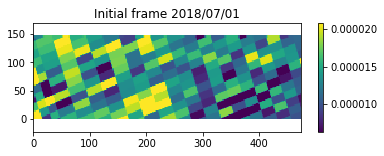

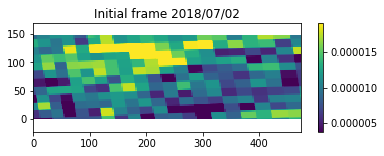

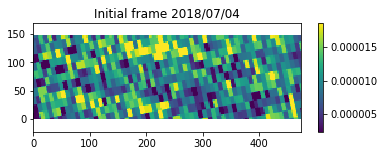

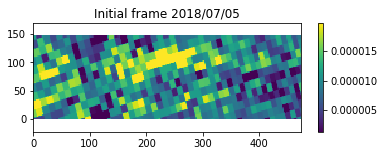

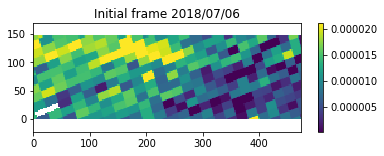

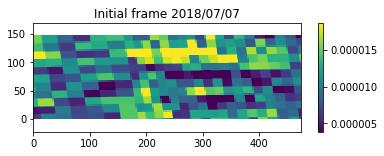

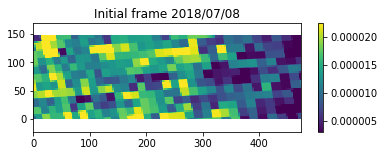

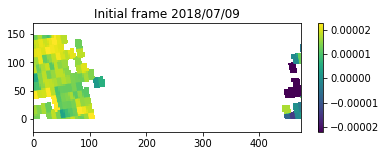

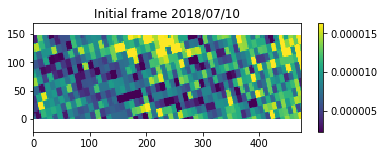

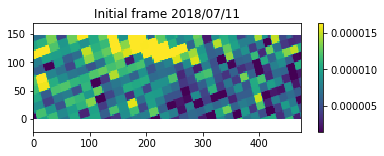

In [133]:
for t in range(10):
    plot_scaled(tropospheric_NO2_per_time_raw[t],
                title='Initial frame '+format(datetime.fromtimestamp(int(timestamp[t])).strftime('%Y/%m/%d')))

The following cells aim at interpolating NO2 pictures in a certain extent. Indeed, we will proceed to 2D interpolations on pictures that do not have too many *NaN* values (it would make no sense to infer values on a grid that have too many missing meaningful values). We thus first deem a threshold of amount of *NaN* values under which we interpolate. Pictures that have too many *NaN* values are simply excluded.

In [134]:
information_trust = np.array(list(map(lambda frame : len(frame[np.isnan(frame)]),
                                      tropospheric_NO2_per_time_raw)))

Text(0.5, 1.0, 'Noise percentage on frames against time')

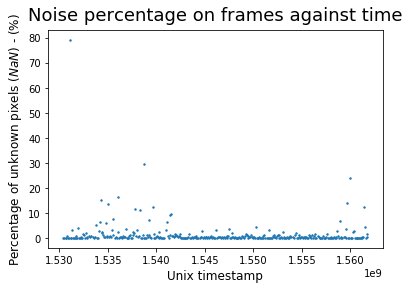

In [135]:
plt.scatter(timestamp, 100*information_trust/(n_x*n_y), s=2)
plt.xlabel(r'Unix timestamp', fontsize=12)
plt.ylabel(r'Percentage of unknown pixels $(NaN)$ - $(\%)$', fontsize=12)
plt.title(r'Noise percentage on frames against time', fontsize=18, pad=10)

In [136]:
thresholds = np.array(list(range(np.max(information_trust))))
amounts = np.array([len(information_trust[information_trust<=threshold])
                    for threshold in thresholds])

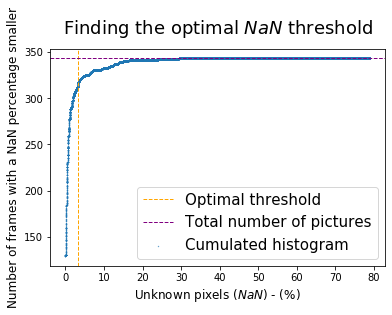

In [137]:
optim_threshold = 2240#calibrated by hand : maximum number of NaN accepted pixels in one picture (5%)

plt.scatter(100*thresholds/(n_x*n_y),
            amounts,
            s=0.1,
            label='Cumulated histogram')
plt.axvline(x=100*optim_threshold/(n_x*n_y),
            linestyle='--',
            linewidth=1,
            c='orange',
            label='Optimal threshold')
plt.axhline(y=n_t, linestyle='--',
            linewidth=1,
            c='purple',
            label='Total number of pictures')
plt.xlabel(r'Unknown pixels $(NaN)$ - $(\%)$', fontsize=12)
plt.ylabel(r'Number of frames with a NaN percentage smaller', fontsize=12)
plt.legend(fontsize=15)
plt.title(r'Finding the optimal $NaN$ threshold', fontsize=18, pad=15)
plt.show()

Hence in the following, we will be trying to interpolate the 2D frames with a number of *NaN* under this threshold.

In [138]:
timestamp = np.array([timestamp[t] for t in range(n_t)
                      if information_trust[t]<optim_threshold])

Time_laps = np.array([Time_laps[t] for t in range(n_t)
                      if information_trust[t]<optim_threshold])

Hours_NO2_pictures = np.array([Hours_NO2_pictures[t] for t in range(n_t)
                      if information_trust[t]<optim_threshold])

Coords_per_time = np.array([Coords_per_time[t,::,::] for t in range(n_t)
                            if information_trust[t]<optim_threshold])

tropospheric_NO2_per_time_raw = np.array([tropospheric_NO2_per_time_raw[t,::,::]
                                          for t in range(n_t)
                                          if information_trust[t]<optim_threshold])

information_trust = np.array([information_trust[t]
                              for t in range(n_t)
                              if information_trust[t]<optim_threshold])


n_t, n_y, n_x = np.shape(tropospheric_NO2_per_time_raw)

Text(0.5, 1.0, 'Noise on frames kept against time')

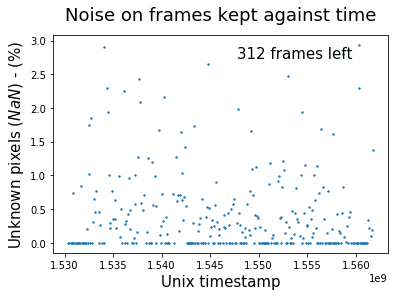

In [139]:
plt.scatter(timestamp, 100*information_trust/(n_x*n_y), s=2)
plt.xlabel(r'Unix timestamp', fontsize=15)
plt.ylabel(r'Unknown pixels $(NaN)$ - $(\%)$', fontsize=15)
plt.figtext(s=str(len(timestamp))+' frames left', x=0.55, y=0.8, fontsize=15)
plt.title(r'Noise on frames kept against time', fontsize=18, pad=15)

#### Data interpolation - 2D linear per frame using *pandas.interpolate*

In [140]:
def extrapolation_method(frame):
    try:
        return np.array(pd.DataFrame(frame).interpolate(method='cubic'))
    except:
        print('linear used !')
        return np.array(pd.DataFrame(frame).interpolate(method='linear',
                                                        limit_area='inside'))

In [141]:
tropospheric_NO2_per_time = np.array(list(map(extrapolation_method,
                                              tropospheric_NO2_per_time_raw)))
print('Interpolation done')

Interpolation done


We try to extrapolate since there are still some *NaN* holes because of the domain geometry: only boundary pixels

In [142]:
tropospheric_NO2_per_time[np.isnan(tropospheric_NO2_per_time)] = 0#set 0 to remaining pixels with NaN values

In [143]:
Time_steps = np.array([datetime.fromtimestamp(int(timestamp[t])).strftime('%Y/%m/%d') for t in range(len(timestamp))])

We now have 312 pictures of NO2, which is a great increase compared to the 129 without NAN values !
Let's process data.

### B) Start with one cluster

In [144]:
### collect locations of gas, oil, and coal
Target_plant_coordinates = power_plants[["longitude","latitude"]][np.isin(power_plants["primary_fuel"],Target_primary_fuels)]

#### Let's see where the plants with fossil primary fuels are located 

In [145]:
lat=18.200178; lon=-66.664513
target_power_plants = power_plants[np.isin(power_plants["primary_fuel"],Target_primary_fuels)].copy()
plot_points_on_map(target_power_plants,0,425,'latitude',lat,'longitude',lon,9)

#### Let's estimate a characteristic distance for the focus on a cluster and apply a conversion for longitudes/latitudes

We are going to set a characteristic distance for gaussian filtering based on this assumption : NO2 molecules have a lifetime that "varie[s] from 0.69 to 0.98 h, with a mean of 0.86 h" regarding literature https://www.tandfonline.com/doi/pdf/10.1080/1073161X.1993.10467221. 
Thus with a typical wind of 3-6 m/s, particles emitted from a source can spread over 10-20 km maximum. Besides, a pixel of satellite data is 3.5km x 7km. Knowing this, it seems natural to use a range of 1km to 20 km characteristic distances and to compute emission factors with different values. 

In [146]:
##estimate characteristic distance and surface of a pixel in NO2 pictures

node = (-67.32431391288841,18.564903861343627)#a corner of the images
max_dist_map_long_lat = np.amax(np.linalg.norm(Coords_per_time[4] - node, axis=2, ord = 2))#maximum distance to this corner
print("The maximum distance in (longitude,latitude) between two points of an image is = {:.4f}".format(max_dist_map_long_lat))

#characteristic distance
dist_in_km = 10#characteristic distance we set, in kilometers
max_dist_map_in_km = 260#approximation of the maximum distance between two points in kilometers source : google maps
dist_in_lon_lat = dist_in_km*max_dist_map_long_lat/max_dist_map_in_km#simply use proportions
print("Characteristic distance within longitude and latitude coordinates change = {:.4f}".format(dist_in_lon_lat))

#surface of a pixel
width_pixel_long = np.abs(Coords_per_time[0][0,0,0]-Coords_per_time[0][0,1,0])
width_pixel_km = width_pixel_long*max_dist_map_in_km/max_dist_map_long_lat
height_pixel_lat = np.abs(Coords_per_time[0][0,0,1]-Coords_per_time[0][1,0,1])
height_pixel_km = height_pixel_lat*max_dist_map_in_km/max_dist_map_long_lat
pixel_surface = height_pixel_km*width_pixel_km*pow(10,6)
print("Width of a pixel (longitude) = {:.4f}".format(width_pixel_long))
print("Width of a pixel (km) = {:.4f}".format(width_pixel_km))
print("Height of a pixel (latitude) = {:.4f}".format(height_pixel_lat))
print("Height of a pixel (km) = {:.4f}".format(height_pixel_km))
print("Surface of a pixel = {:.4f} m^2".format(pixel_surface))

The maximum distance in (longitude,latitude) between two points of an image is = 2.2304
Characteristic distance within longitude and latitude coordinates change = 0.0858
Width of a pixel (longitude) = 0.0045
Width of a pixel (km) = 0.5230
Height of a pixel (latitude) = 0.0045
Height of a pixel (km) = 0.5236
Surface of a pixel = 273828.6904 m^2


#### Let's select emissions with a gaussian distribution centered on a cluster 

The gaussian filter is motivated by a physical background : gaussian fields are commonly used to model diffusion processes, which is the case here with a local source and wind creating a flow of molecules. Besides, we use a sum instead of an integral that would be the better computation physically, as a first approximation and taking advantage of the high pixel resolution.

In [147]:
def Field_evolution_in_a_location(loc_long,loc_lat,field_over_time,coordinates_over_time, plot_map = False):
    '''We use distance in coordinates as a weight to count emissions and store total over time'''
    node = [loc_long,loc_lat]#the center of the filter : source coordinates
    nb_time_steps = field_over_time.shape[0]#amount of time steps
    Weighted_total_over_time = []#we store the sum of tropospheric density pixel after gaussian filtering
    Days_kept = []#to know which days are kept
    for t in range(nb_time_steps):
        dist = np.sum((coordinates_over_time[t] - node)**2, axis=2)#distance^2 between each pixel and the source pixel
        weighted_field = field_over_time[t]*np.exp(-dist/(2*dist_in_lon_lat**2))#we apply weighing
        if(not np.isnan(weighted_field).any()):#check nan values 
            Days_kept.append(t)
            if(plot_map):#to plot the 2D fields
                print(t)
                Y,X = np.meshgrid(np.arange(475),np.arange(148))
                plt.pcolormesh(Y,X, weighted_field)
                plt.colorbar()
                plt.show()
            Weighted_total_over_time.append(np.sum(weighted_field, axis = (0,1)))#we append the weighed sum
    return(np.array(Weighted_total_over_time),np.array(Days_kept))

In [148]:
#Let's focus on an example
target_plant_index = 23#example of plant index
cluster = [23]#example of list of indexes : a cluster of plants
long_target, lat_target = float(power_plants["longitude"][target_plant_index]), float(power_plants["latitude"][target_plant_index])
print('focus : longitude, latitude = {}, {}'.format(long_target,lat_target))
W_total_per_time, time_kept = Field_evolution_in_a_location(long_target,  lat_target,tropospheric_NO2_per_time,Coords_per_time, plot_map = False)    

focus : longitude, latitude = -66.6967988882682, 18.4691016031558


Let's create a function to get datetime dates instead of strings

In [149]:
def to_datetimedates(string_date_list, format_str = '%Y%m%d'):
    '''takes a list of strings and returns a list of datetime dates'''
    Date_list = []
    for date_str_ in string_date_list:
        date_ = datetime.strptime(date_str_, format_str)
        Date_list.append(date_)
    return(np.array(Date_list))

def to_stringdates(date_list, format_str = '%Y/%m/%d'):
    '''takes a list of datetime dates and returns a list of string dates'''
    Date_string_list = []
    for date_ in date_list:
        date_str_ = date_.strftime(format_str)
        Date_string_list.append(date_str_)
    return(np.array(Date_string_list))

We store the dates of the files without NAN in the NO2 dataset:

In [150]:
dates_NO2 = to_datetimedates(Time_steps,format_str = '%Y/%m/%d' )
dates_NO2_string = Time_steps
Hours_NO2_instant = to_datetimedates(Hours_NO2_pictures,format_str = '%H%M%S')

In [151]:
def display_date_histogram_per_month(datetime_list):
    '''Takes a list of datetime objects as input and displays a histogram of month repartition of those dates'''
    dtm = lambda x: x.month
    months = list(map(dtm, datetime_list))
    fig, ax = plt.subplots()
    bins = np.arange(1,14)
    ax.hist(months,bins = bins, edgecolor="k", align='left')
    plt.title("Repartition of samples considered per month")
    plt.xlabel("Month")
    plt.ylabel("Amount of samples")
    ax.set_xticks(bins[:-1])
    ax.set_xticklabels([datetime(2020, i, 1).strftime('%b') for i in bins[:-1]])
    plt.show()

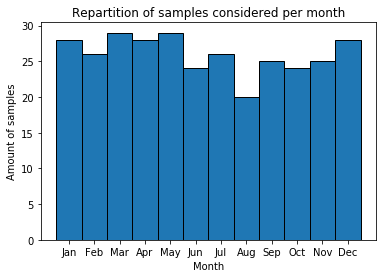

In [152]:
display_date_histogram_per_month(dates_NO2)

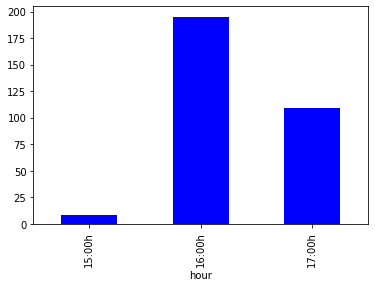

In [153]:
df = pd.DataFrame({'hour' :Hours_NO2_instant})  
df.set_index('hour', drop=False, inplace=True)
df = df['hour'].groupby(pd.Grouper(freq='60Min')).count()
ax = df.plot(kind='bar', color='b')
ticklabels = df.index.strftime('%H:%Mh')
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
plt.show()

The histogram above represents the repartition of the time when NO2 pictures were taken (UTC).

#### Remarks on the dates and hours of observed and kept data

- Most of the acquisition times are between 16 and 17 UTC. This has several consequences:
    - We will need to deduce daily emissions from a picture taken at those moments : as we mentioned above, NO2 molecules have a lifetime that "varie[s] from 0.69 to 0.98 h, with a mean of 0.86 h". Thus for a first approximation we will deem daily emission multiplying the instantaneous values with the number of NO2 lifetimes per day : 24*1/0.86
    - We will need to merge with GFS dates and hours in the proper way in next sections.


- The date histogram above highlights the fact that the amount of daily NO2 values we considered after NAN processing and interpolation is quite regular (compared to a majority of pictures during summer when excluding any picture with NAN values).
This enables us to avoid a bias in our results since research papers such as https://www.atmos-chem-phys.net/19/8863/2019/acp-19-8863-2019.pdf have explained that "[They] expect background influences to be relatively higher at rural than urban sites, and higher in summer (lightning, soil, intercontinental transport; Fischer et al.,2014) than in winter." and that "There  is  indeed  evidence  that  free  tropospheric  NO2 makes  a  large  contribution  to  OMI  NO2 columns  and  that models  underestimate  this  contribution".

#### Evolution of the total mass of emissions above the cluster, after nan exclusion

In [154]:
#constants inherent in NO2 data
Instant_to_day = 24*1/0.86 #since picture is instantaneous and NO2 have 0.86h lifetime in average
Molar_mass_of_NO2 = 46.0055/1000 #kg/mol
NO2_to_NOx = 1.32 #mass factor to emissions cf. "NOx lifetimes and emissions of cities and power plants in polluted background estimated by satellite observations", Fei Liu et al.

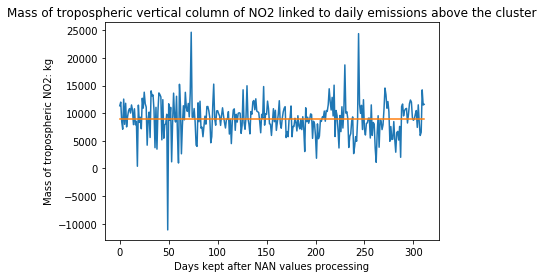

In [155]:
#process one particular cluster
mean_on_kept_period = Instant_to_day*Molar_mass_of_NO2*pixel_surface*np.mean(W_total_per_time)##mean of daily NO2 mass close to the plant
plt.plot(Instant_to_day*Molar_mass_of_NO2*pixel_surface*W_total_per_time)
plt.plot(mean_on_kept_period*np.ones(np.shape(W_total_per_time)))
plt.xlabel("Days kept after NAN values processing")
plt.ylabel("Mass of tropospheric NO2: kg")
plt.title("Mass of tropospheric vertical column of NO2 linked to daily emissions above the cluster")
plt.show()

#### Mix with plant dataset to get an approximation of the emission factor of a cluster

In [156]:
print("Mean of mass of tropospheric vertical column of NO2 linked to daily emissions above the cluster : = {:.4f} kg".format(mean_on_kept_period))
first_approx_emission = 365*NO2_to_NOx*mean_on_kept_period
generation_per_plant_cluster = power_plants["estimated_generation_gwh"][cluster]
generation_cluster = np.sum(np.array(generation_per_plant_cluster))
first_approx_emission_factor = first_approx_emission/generation_cluster
print("NOx emission (average) over one year linked to the cluster = {:.4f} kg".format(first_approx_emission))
print("NOx emission factor (average) over one year linked to the cluster : = {:.4f} NOx kg/GWh".format(first_approx_emission_factor))
print("Documented values are between 100 (300 in the introduction table) and 1000 (4000 in the same table) kg/GWh") 
#see other documented values here : https://books.google.fr/books?id=2L-OIrTBiRMC&pg=PA176&lpg=PA176&dq=NO2x+kg/GWh&source=bl&ots=HpOZw0yPip&sig=ACfU3U3i0w4Ya5ex2vfwOwjNMk27JiG7qg&hl=fr&sa=X&ved=2ahUKEwjws4H_vOPnAhVoDWMBHds2BdAQ6AEwAHoECAcQAQ#v=onepage&q=NO2x%20kg%2FGWh&f=false

Mean of mass of tropospheric vertical column of NO2 linked to daily emissions above the cluster : = 9022.7882 kg
NOx emission (average) over one year linked to the cluster = 4347179.3677 kg
NOx emission factor (average) over one year linked to the cluster : = 3144.4676 NOx kg/GWh
Documented values are between 100 (300 in the introduction table) and 1000 (4000 in the same table) kg/GWh


### C) Try approach per cluster and sum to get a first estimation for the whole island

This section is a generalization of the previous one : we create a set of clusters grouping fossil plants regarding their coordinates and the characteristic distance used. We compute emissions for each cluster and get elecricity generation too. In the end, we combine both information to estimate emission factors.

In [157]:
#created by hand with the map
Clusters = [[16],[2,12,14],[23],[18],[17,3,30],[13],[11],[19],[28,15,10,1]]#one cluster : one list of indexes

In [158]:
def barycenter(coord_list):
    '''gets a list of coordinates and returns the coordinates of the barycenter'''
    return(np.sum(np.array(coord_list), axis = 0)/len(coord_list))

def index_to_coordinates(ind):
    '''gives the coordinates in longitude, latitude of the plant with index = ind in the dataframe'''
    long_,lat_ = float(power_plants["longitude"][ind]), float(power_plants["latitude"][ind])
    return([long_,lat_])

Let's store the barycenter coordinates of each cluster:

In [159]:
Barycenters = []
for clust in Clusters:
    coord_clust = [index_to_coordinates(ind) for ind in clust]
    bar = barycenter(coord_clust)
    Barycenters.append(bar)

We define a function to generalize the approach described above: for each cluster we compute the evolution of NO2 density per day, weighed by the gaussian filter and computed as a total (sum) in the troposphere.

In [160]:
def track_NO2_emission_density_per_cluster_per_time(Clusters_,Barycenters_):
    '''Takes a list of cluster indexes and the coordinates of the barycenter of each cluster, returns the total NO2 emissions'''
    NO2_per_cluster_per_time = []
    for k in range(len(Clusters_)):
        print("Dealing with cluster : {}".format(k))
        barycenter_ = Barycenters_[k]
        W_total_per_time, _ = Field_evolution_in_a_location(barycenter_[0],barycenter_[1],tropospheric_NO2_per_time,Coords_per_time)
        NO2_per_cluster_per_time.append(W_total_per_time)
    return(np.array(NO2_per_cluster_per_time))

Let's apply it to our clusters:

In [161]:
Time_series_NO2_density_per_cluster = track_NO2_emission_density_per_cluster_per_time(Clusters, Barycenters)

Dealing with cluster : 0
Dealing with cluster : 1
Dealing with cluster : 2
Dealing with cluster : 3
Dealing with cluster : 4
Dealing with cluster : 5
Dealing with cluster : 6
Dealing with cluster : 7
Dealing with cluster : 8


#### Let's see evolution over time and distribution of emissions

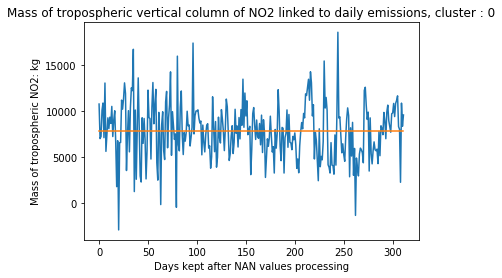

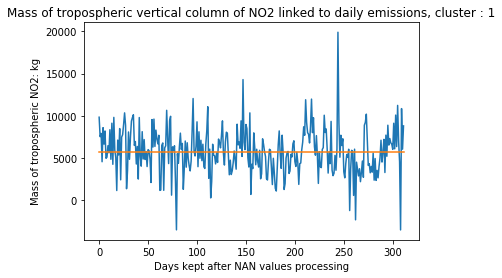

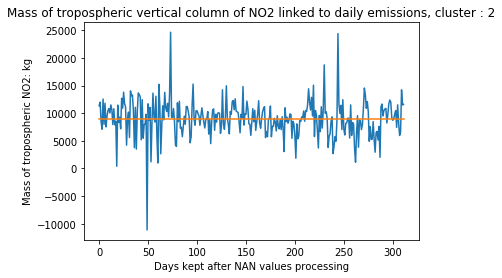

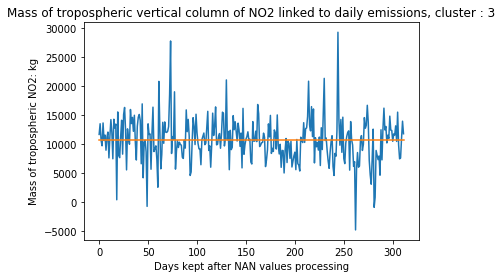

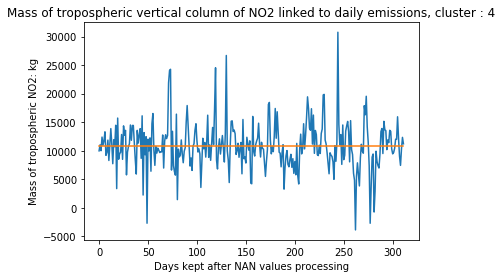

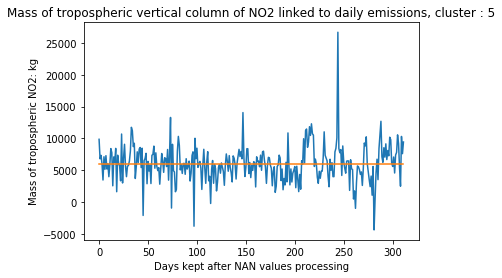

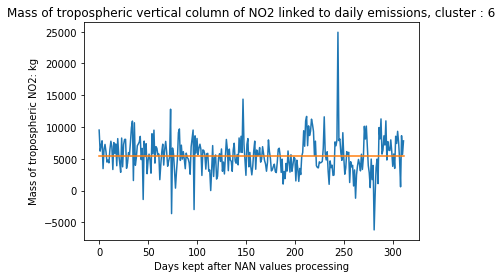

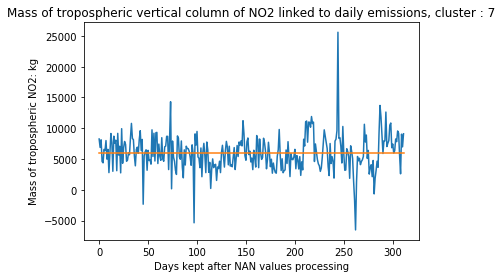

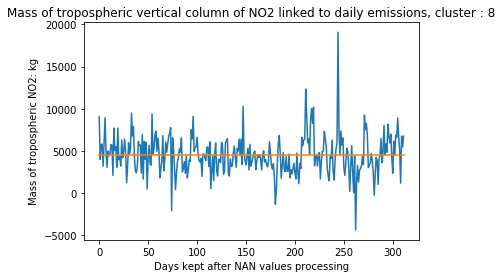

In [162]:
#evolution over time per cluster
Mean_per_cluster = []
for clust_ind in range(len(Clusters)):
    mean_on_kept_period = Instant_to_day*Molar_mass_of_NO2*pixel_surface*np.mean(Time_series_NO2_density_per_cluster[clust_ind])##mean of daily NO2 mass close to the plant
    Mean_per_cluster.append(mean_on_kept_period)
    plt.plot(Instant_to_day*Molar_mass_of_NO2*pixel_surface*Time_series_NO2_density_per_cluster[clust_ind])
    plt.plot(mean_on_kept_period*np.ones(np.shape(Time_series_NO2_density_per_cluster[clust_ind])))
    plt.xlabel("Days kept after NAN values processing")
    plt.ylabel("Mass of tropospheric NO2: kg")
    plt.title("Mass of tropospheric vertical column of NO2 linked to daily emissions, cluster : {}".format(clust_ind))
    plt.show()
    
Mean_per_cluster = np.array(Mean_per_cluster)

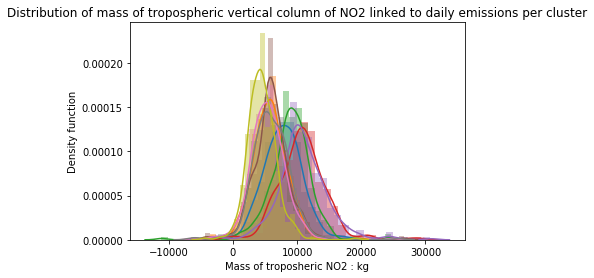

In [163]:
#distribution per cluster
for clust_ind in range(len(Clusters)):
    sns.distplot(Instant_to_day*Molar_mass_of_NO2*pixel_surface*Time_series_NO2_density_per_cluster[clust_ind])
    plt.xlabel("Mass of troposheric NO2 : kg")
    plt.ylabel("Density function")

plt.title("Distribution of mass of tropospheric vertical column of NO2 linked to daily emissions per cluster")
plt.show()

#### Mix with plant dataset to get an approximation of the emission factor

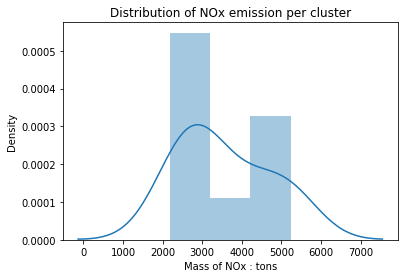

Annual total production per cluster = [ 1550.00322157  9397.90273467  1382.48503748   295.90970594
  9076.5091782    295.90970594   295.90970594    33.51478879
 11074.85088593] GWh


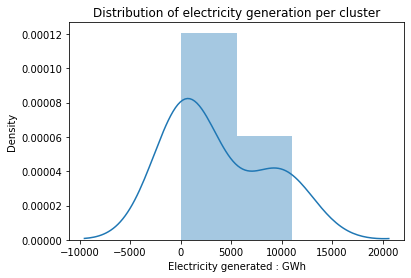

Mean per cluster  = 14363.2036 NOx kg/GWh
Documented values are between 100 (300 in the introduction table) and 1000 (4000 in the same table) kg/GWh


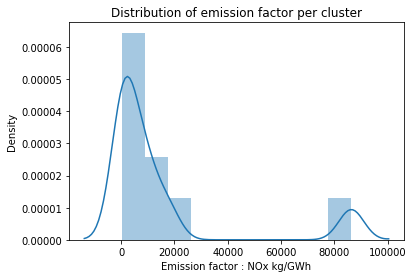

In [164]:
#emissions
first_approx_emission_per_clust = 365*NO2_to_NOx*Mean_per_cluster
sns.distplot(first_approx_emission_per_clust/1000)
plt.title("Distribution of NOx emission per cluster")
plt.xlabel("Mass of NOx : tons")
plt.ylabel("Density")
plt.show()

#electricity generation
generation_per_clust = []
for cluster in Clusters:
    generation_inside_clust = np.array(power_plants["estimated_generation_gwh"][cluster])
    generation_per_clust.append(np.sum(generation_inside_clust))    
generation_per_clust = np.array(generation_per_clust)
print("Annual total production per cluster = {} GWh".format(generation_per_clust))

sns.distplot(generation_per_clust)
plt.title("Distribution of electricity generation per cluster")
plt.xlabel("Electricity generated : GWh")
plt.ylabel("Density")
plt.show()

#emission factor
first_approx_emission_factor_global = first_approx_emission_per_clust/generation_per_clust
#print("Mean NOx emission factor over one year per cluster : = {} NOx kg/GWh".format(first_approx_emission_factor_global))
print("Mean per cluster  = {:.4f} NOx kg/GWh".format(np.mean(first_approx_emission_factor_global)))
print("Documented values are between 100 (300 in the introduction table) and 1000 (4000 in the same table) kg/GWh")
#see for other values : https://books.google.fr/books?id=2L-OIrTBiRMC&pg=PA176&lpg=PA176&dq=NO2x+kg/GWh&source=bl&ots=HpOZw0yPip&sig=ACfU3U3i0w4Ya5ex2vfwOwjNMk27JiG7qg&hl=fr&sa=X&ved=2ahUKEwjws4H_vOPnAhVoDWMBHds2BdAQ6AEwAHoECAcQAQ#v=onepage&q=NO2x%20kg%2FGWh&f=false

sns.distplot(first_approx_emission_factor_global)
plt.title("Distribution of emission factor per cluster")
plt.xlabel("Emission factor : NOx kg/GWh")
plt.ylabel("Density")
plt.show()

#### Let's deduce an emission factor for the whole island:

In [165]:
sum_generation = power_plants["estimated_generation_gwh"].sum()
print("Mean emission factor for electricity generation in Puerto Rico = {:.4f} NOx kg/GWh".format(first_approx_emission_per_clust.sum()/sum_generation))

Mean emission factor for electricity generation in Puerto Rico = 944.2563 NOx kg/GWh


#### Comments on those results

Several remarks can be made on those results :

- First point : on average and in total, we tend to overestimate emissions and thus emission factors with this gaussian approach. This can be linked to various assumptions and factors:

    - As we mentioned previously, we must have in mind that natural background could account for a large part of tropospheric NO2 detected. We will investigate this point in the next section.
    
    - One can notice with a rapid view over the map that in most cases, plants are surrounded by cities, or even by aiports. It seems difficult to distinguish those sources of NOx emissions with the current model. A way to address this issue could be to focus only on isolated plants and to select a small characteristic distance. Nonetheless, a compromise has to be taken not to underestimate emissions because of a too small distance, and generalization with only a small sample of the dataset can be questioned.
    
    - To estimate daily emissions from instantaneous pictures of NO2 we multiplied instantaneous NO2 density with a factor equal to the number of lifetimes of NO2 molecules in a day : 24*1/0.86 in average. Nonetheless one could imagine that plants are working less during the night. This is thus an upper bound to plant emissions.
    

- We have had to exclude or to modify some values : the estimated generation of the coal and hydro plants were not consistent and we had a lot of NAN values in satellite data (maybe due to cloud coverage that entails some reflection, since NO2 density is deemed thanks to optic properties).



- We have set the characteristic distance for gaussian filtering based on this assumption : NO2 molecules have a lifetime that "varie[s] from 0.69 to 0.98 h, with a mean of 0.86 h" regarding literature https://www.tandfonline.com/doi/pdf/10.1080/1073161X.1993.10467221. Thus with a typical wind of 3 m/s, particles emitted from a source can spread over 10-20 km maximum. Besides, a pixel of satellite data is 3.5km x 7km. Knowing this, it seems natural to use a range of 1km to 20 km characteristic distances and compute emission factors with different values. 


- Clusters have to be thought in accordance with the characteristic distance. Indeed, if this latter is greater or almost equal to the distance between two clusters, we will face some issues counting twice some emissions. Clusters must thus be modified having in mind this principle when the characteristic distance is altered.


- According to dataset description, the estimation of generated electricity in the power plants file is about 2015, and our NO2 satellite data is linked to 2018. As an approximation, we assumed that emissions data for 2015 and 2018 were close. Some ways to deal with this date difference would be to incorporate a new dataset for 2018, or to use activity models over time to deduce from 2015 data an approximation of 2018 data.

##  IV - Second attempt : add new features : horizontal wind, temperature and relative humidity and create a dataframe

The aim of this section is to deal with limitations of the previous one we noticed above. 

Indeed, as depicted in https://www.researchgate.net/publication/251439024_Effects_of_soil_moisture_and_temperature_on_NO_NO2_and_N2O_emissions_from_European_forest_soils, humidity and temperature are features that play no mean part in natural NO2 emissions. The importance of this background emission was mentioned previsouly. 


Besides, our model with gaussian masks was underpinned by the assumption of a typical wind speed of 3-6m/s, and did not take into account this variable to compute emissions from NO2 2D fields. 

We are thus trying here to improve the previous work, taking into account wind speed and orientation, relative humidity and temperature as additional features. We fit 1D models taking into account those new variables, as bolstered by the following article : https://www.atmos-chem-phys.net/16/5283/2016/acp-16-5283-2016.pdf. This latter was inspiring as a valuable source of information.

### A) Extract GFS 2D fields

In [166]:
path = 'kaggle/input/ds4g-environmental-insights-explorer/eie_data/gfs/'

gfs_coords_per_time = {12 : [], 18 : []}
gfs_wind_per_time = {12 : [], 18 : []}
gfs_temperature_per_time = {12 : [], 18 : []}
gfs_humidity_per_time = {12 : [], 18 : []}
gfs_time_laps = {12 : [], 18 : []}

for extract_iteration, filename in enumerate(os.listdir(path)):
    date_ = filename[4:14]
    if date_[:-2] in Time_laps[:,0]:  #we extract only on the days of interest
        hour_ = int(date_[-2:])
        if hour_ in [12, 18]:  #we extract only hours close to NO2 acquisition hour 
            #print('Extracting file number {} : '.format(extract_iteration)+filename)
            gfs_time_laps[hour_].append(date_)
            path_ = path+filename
            gfs_coords_per_time[hour_].append(coordinates(path_))
            gfs_wind_per_time[hour_].append(rio.open(path_).read()[3:5])
            gfs_temperature_per_time[hour_].append(rio.open(path_).read()[0])
            gfs_humidity_per_time[hour_].append(rio.open(path_).read()[2])

Sort data by date:

In [167]:
gfs_dates = dict()
gfs_timestamp = dict()

for hour in [12, 18]:        
    gfs_dates[hour] = to_datetimedates(np.array(gfs_time_laps[hour]),
                                       format_str='%Y%m%d%H')
    gfs_timestamp[hour] = np.array([datetime.timestamp(date)
                                    for date in gfs_dates[hour]])
    gfs_coords_per_time[hour] = np.array(gfs_coords_per_time[hour])
    gfs_wind_per_time[hour] = np.array(gfs_wind_per_time[hour])
    gfs_temperature_per_time[hour] = np.array(gfs_temperature_per_time[hour])
    gfs_humidity_per_time[hour] = np.array(gfs_humidity_per_time[hour])

    print('sorting the data for hour '+str(hour))
    total_data = {instant: (date, coords, wind, temperature, humidity)
                  for instant, date, coords, wind, temperature, humidity
                  in zip(gfs_timestamp[hour],
                         gfs_dates[hour],
                         gfs_coords_per_time[hour],
                         gfs_wind_per_time[hour],
                         gfs_temperature_per_time[hour],
                         gfs_humidity_per_time[hour])}
    
    gfs_timestamp[hour] = np.array(sorted(gfs_timestamp[hour]))
    gfs_dates[hour] = np.array([total_data[instant][0]
                                for instant in gfs_timestamp[hour]])
    gfs_coords_per_time[hour] = np.array([total_data[instant][1]
                                          for instant in gfs_timestamp[hour]])
    gfs_wind_per_time[hour] = np.array([total_data[instant][2]
                                        for instant in gfs_timestamp[hour]])
    gfs_temperature_per_time[hour] = np.array([total_data[instant][3]
                                               for instant in gfs_timestamp[hour]])
    gfs_humidity_per_time[hour] = np.array([total_data[instant][4]
                                            for instant in gfs_timestamp[hour]])

sorting the data for hour 12
sorting the data for hour 18


Let's check date information about those files

In [168]:
if (gfs_dates[12].shape == np.unique(gfs_dates[12]).shape) and \
    (gfs_dates[18].shape == np.unique(gfs_dates[18]).shape):
    print("No duplicates in GFS data")
else:
    print("Duplicates, need to process dates")
    
if gfs_dates[12].shape == gfs_dates[18].shape:
    print("Same amount of data for 12 UTC and 18 UTC")
    if len(gfs_dates[12]) == len(timestamp):
        print("Data is known for day of NO2 data")
    else:
        print("Data misses for some day of NO2 data")
else:
    print("Issue : different amount of data for 12 UTC and 18 UTC")

No duplicates in GFS data
Same amount of data for 12 UTC and 18 UTC
Data is known for day of NO2 data


#### Let's process the wind vector field stored

We know that the U component is related to East-West axis and oriented positive towards East, V is related to North-South axis and oriented positive towards North. Fortunately satellite pictures which are provided are oriented East-West and North-South. Besides, as we mentioned above, the area is small enough to neglect 3D projections to deal with coordinates.

We need first to compute the norm of the wind field, to know whether the previous hypothesis on diffusion was consistent.

In [169]:
def plot_wind_norm(wind_field):
    '''Takes a wind 2D field as input and displays its scalar norm field through a color map'''
    norm_field = np.linalg.norm(wind_field, axis = 0, ord = 2)
    Y,X = np.meshgrid(np.arange(475),np.arange(148))
    plt.pcolormesh(Y,X, norm_field)
    plt.xlabel('Pixel index in East-West direction')
    plt.ylabel('Pixel index in North-South direction')
    plt.title('Wind norm over the island')
    cb = plt.colorbar()
    cb.set_label('m/s')

We can display the scalar field over the island for the first wind file :

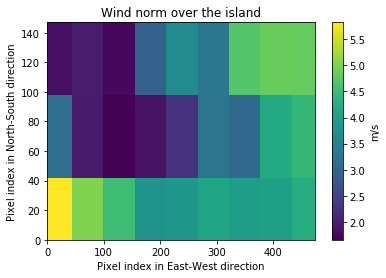

In [170]:
plot_wind_norm(gfs_wind_per_time[12][0])

We can see that for some particular days and locations, the speed is higher than we assumed. Let's compute an evolution over time of the average norm over the island:

In [171]:
def spatial_average_over_time(field, vector_field = True):
    '''Takes a field over time above Puerto Rico as input, and returns its spatial average over time'''
    '''If the field is a vector field, then its average norm is returned over time (vector_field = True)'''
    if(vector_field):
        return(np.mean(np.linalg.norm(field, axis = 1, ord = 2), axis = (1,2)))
    else:
        return(np.mean(field, axis = (2,3)))

In [172]:
spatial_wind_norm_average_over_time = {12 : spatial_average_over_time(gfs_wind_per_time[12]),
                                       18 : spatial_average_over_time(gfs_wind_per_time[18])}

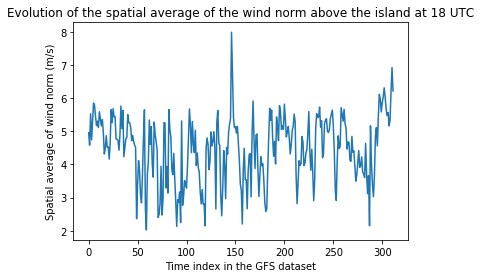

In [173]:
plt.plot(spatial_wind_norm_average_over_time[18])
plt.xlabel("Time index in the GFS dataset")
plt.ylabel("Spatial average of wind norm (m/s)")
plt.title("Evolution of the spatial average of the wind norm above the island at 18 UTC")
plt.show()

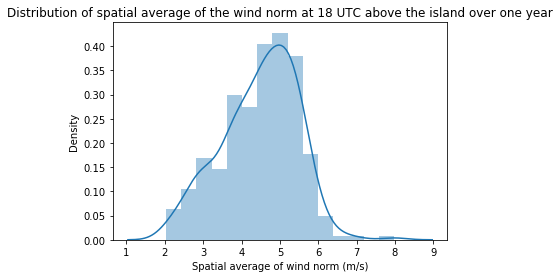

In [174]:
sns.distplot(spatial_wind_norm_average_over_time[18])
plt.title("Distribution of spatial average of the wind norm at 18 UTC above the island over one year")
plt.xlabel("Spatial average of wind norm (m/s)")
plt.ylabel("Density")
plt.show()

In [175]:
print("Spacetime average of the wind norm above the island at 12 UTC = {:.4f} m/s".format(np.mean(spatial_wind_norm_average_over_time[12])))
print("Spacetime average of the wind norm above the island at 18 UTC = {:.4f} m/s".format(np.mean(spatial_wind_norm_average_over_time[18])))

Spacetime average of the wind norm above the island at 12 UTC = 3.4644 m/s
Spacetime average of the wind norm above the island at 18 UTC = 4.4740 m/s


Though the distribution is not gaussian, we can notice that the evolution of the spatial average of the wind norm and its distribution enable to confirm the assumption taken in the previous section to select the characteristic distance and to compute the emission factor. Our first approximation was not absurd.

#### We are going to deal with streamlines before creating a model

First, let's deal with wind orientation and display stream lines (remark : a vector field is everywhere tangent to its streamlines. Thus we can assess direction).

In [176]:
def plot_wind_streamline(wind_field):
    '''Takes a 2D wind field as input and returns its streamlines'''
    Y,X = np.meshgrid(np.arange(475),np.arange(147,-1,-1))
    U, V = wind_field[0], wind_field[1]
    plt.title("Streamlines of the wind above the island")
    plt.xlabel('Pixel index in East-West direction')
    plt.ylabel('Pixel index in North-South direction')
    strm = plt.streamplot(Y, X, U, V, color=np.sqrt(U**2+V**2),linewidth= 2, cmap=plt.cm.viridis)
    cb = plt.colorbar(strm.lines)
    cb.set_label('m/s')

We are going to display the 2 streamline pictures of the wind inherent in one day of wind data. 

Our concern is the following : if wind direction evolves too much over a day, we won't be easily able to use wind direction to process NO2 daily data taken between 15h and 18h UTC.

We display streamlines for date and time : 2018-07-02 12:00:00


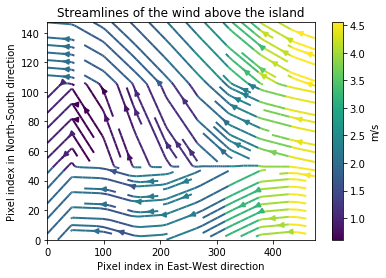

We display streamlines for date and time : 2018-07-02 18:00:00


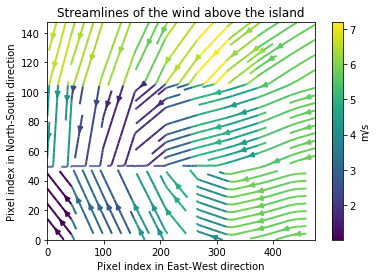

In [177]:
day_index = 1 #day index in wind observation
for hour in [12, 18]:
    print("We display streamlines for date and time : {}".format(gfs_dates[hour][day_index]))
    plot_wind_streamline(gfs_wind_per_time[hour][day_index])
    plt.show()

We are going to merge the two data sets of GFS given for 12 UTC and 18 UTC for each day in order to have an approximation of the wind, temperature and humidity during the $NO_2$ acquistion stored in *Hours_NO2_instant* : 

$$ f(x,y,t_{aq}) \simeq \big(1-\alpha(t_{aq})\big) f(x,y,t_0) + \alpha(t_{aq}) f(x,y,t_1)$$

$$ \alpha(t_{aq})=\frac{t_{aq}-t_0}{t_1-t_0} $$

for $t_{aq}$ (given in hours UTC) in the range : $[t_0=12h, t_1=18h]$

We can see first that the GFS coordinates do not depend on time, so they can be kept in a single array *gfs_coords* :

In [178]:
gfs_coords = gfs_coords_per_time[12][0]
print(np.max(abs(gfs_coords_per_time[12]-gfs_coords)))
print(np.max(abs(gfs_coords_per_time[18]-gfs_coords)))

0.0
0.0


So we can proceed to direct convex combinations over wind, temperature and humidity arrays :

In [179]:
alphas = np.array(list(map(lambda hour :
                           (hour.hour+hour.minute/60+hour.second/3600-12)/(18-12),
                           Hours_NO2_instant)))
if np.min(alphas)<0 or np.max(alphas)>1:
    print('Issue : there is an acquisition time not between 12h and 18h UTC')

In [180]:
wind_per_day = np.array(list(map(lambda x : x[0]*x[1],
                                 zip(1-alphas, gfs_wind_per_time[12]))))+\
               np.array(list(map(lambda x : x[0]*x[1],
                                 zip(alphas, gfs_wind_per_time[18]))))
temperature_per_day = np.array(list(map(lambda x : x[0]*x[1],
                                        zip(1-alphas, gfs_temperature_per_time[12]))))+\
                      np.array(list(map(lambda x : x[0]*x[1],
                                        zip(alphas, gfs_temperature_per_time[18]))))
humidity_per_day = np.array(list(map(lambda x : x[0]*x[1],
                                     zip(1-alphas, gfs_humidity_per_time[12]))))+\
                   np.array(list(map(lambda x : x[0]*x[1],
                                     zip(alphas, gfs_humidity_per_time[18]))))

Estimated streamlines during NO2 acquisition for date 2018/07/01 and time 16h:12 UTC


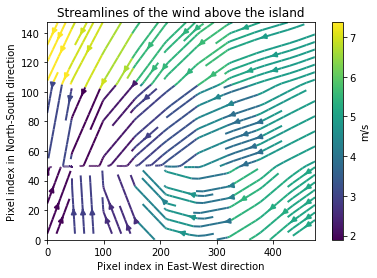

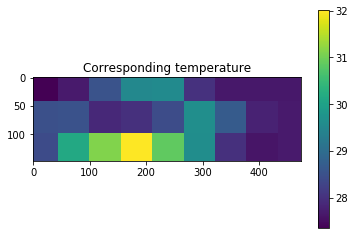

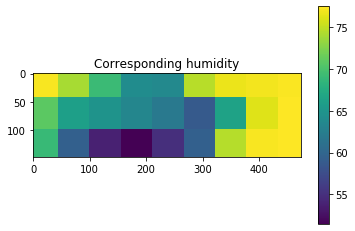

In [181]:
day_index = 0
print("Estimated streamlines during NO2 acquisition for date {} and time {} UTC".format(\
                Time_steps[day_index],Hours_NO2_instant[day_index].strftime('%Hh:%M')))
plot_wind_streamline(wind_per_day[day_index])
plt.show()
plt.title("Corresponding temperature")
plt.imshow(temperature_per_day[day_index])
plt.colorbar()
plt.show()
plt.title("Corresponding humidity")
plt.imshow(humidity_per_day[day_index])
plt.colorbar()
plt.show()

### B) From 2D fields to 8 1D fields

#### We create functions to extract from a 2D field some 1D fields along specific directions and in a perimeter of a location

In [75]:
Convention_directions = np.array(['North', 'South', 'East', 'West', 'N-E', 'N-W', 'S-E', 'S-W'])
Convention_vectors = np.array([(0,1),(0,-1),(1,0),(-1,0),(1/np.sqrt(2),1/np.sqrt(2)),(-1/np.sqrt(2),1/np.sqrt(2)),(1/np.sqrt(2),-1/np.sqrt(2)),(-1/np.sqrt(2),-1/np.sqrt(2))])

def get_surrounding(center_coords_, radius_, field_values_, field_coordinates_, plot_mask_ = False):
    '''Extracts the surrounding of a point with a radius, and get field values in this surrounding'''
    '''Radius : km, field_coordinates and center_cords : (lon,lat), field_values : 2D field'''
    Radius_lon_lat = radius_*max_dist_map_long_lat/max_dist_map_in_km#conversion as mentioned in the previous section
    Disk_mask = (np.linalg.norm(field_coordinates_ - center_coords_, axis=2, ord = 2) <= Radius_lon_lat).astype(int)  
    if(plot_mask_):
        if(field_coordinates_[0,0][1]>field_coordinates_[1,0][1]):
            Y,X = np.meshgrid(np.arange(475),np.arange(147,-1,-1))
        else:
            Y,X = np.meshgrid(np.arange(475),np.arange(148))
        plt.pcolormesh(Y,X, Disk_mask*field_values_)
        plt.colorbar()
    return(Disk_mask*field_values_)

def get_8_directions(center_coords,radius,field_values,field_coordinates, plot_extract = False, nb_intervals = 10):
    '''Computes 8 density lines of the 2D scalar field around the point with coordinates : center_coords and radius limits'''
    '''Lines : towards North, South, East, West, N-E, N-W, S-E, S-W using (longitude, latitude) coordinates'''
    
    translated_coordinates = field_coordinates-center_coords#origin : center_coords
    surronding_values = get_surrounding(center_coords,radius,field_values,field_coordinates)
    N_vector = (0,1)
    S_vector = (0,-1)
    E_vector = (1,0)
    W_vector = (-1,0)
    NE_vector = (1/np.sqrt(2),1/np.sqrt(2))
    NW_vector = (-1/np.sqrt(2),1/np.sqrt(2))
    SE_vector = (1/np.sqrt(2),-1/np.sqrt(2))
    SW_vector = (-1/np.sqrt(2),-1/np.sqrt(2))
    directions = [N_vector,S_vector,E_vector,W_vector,NE_vector,NW_vector,SE_vector,SW_vector]
    scalar_products = np.array([np.dot(translated_coordinates,direction) for direction in directions])
    Directional_densities = []
    
    for direction_index in range(len(directions)):
        
        #we select scalar products and values in the direction and below radius
        mask = (np.argmax(scalar_products, axis = 0) == direction_index).copy()
        selected_locations = (scalar_products[direction_index][mask])[surronding_values[mask] > 0]
        selected_values = (surronding_values[mask])[surronding_values[mask] > 0]
        
        #we create a discrete line to compute a density
        discrete_intervals = np.linspace(0,radius*max_dist_map_long_lat/max_dist_map_in_km, nb_intervals)
        interval_correspondance = np.digitize(selected_locations,discrete_intervals)
        line_data = pd.DataFrame(columns = ["Values", "interval_id"], data = np.transpose(np.array([selected_values,interval_correspondance])))
        interval_data = pd.DataFrame(columns = ["interval_index", "upper_bound"], data =  np.transpose(np.array([np.arange(nb_intervals),discrete_intervals])))
        discretize_density = line_data.groupby(["interval_id"]).mean()#we select the mean per interval along the direction
        density_with_metric = discretize_density.join(interval_data.set_index("interval_index"))
        Directional_densities.append(density_with_metric)
        
        if(plot_extract):
            Y,X = np.meshgrid(np.arange(475),np.arange(148))
            plt.pcolormesh(Y,X, mask.astype(int)*surronding_values)
            plt.show()
            plt.plot(density_with_metric["upper_bound"],density_with_metric["Values"])
            plt.show()
    return(Directional_densities)

def vect_to_direction(vect):
    '''Gives the index of the direction corresponding to the vector in North, South, East, West, N-E, N-W, S-E, S-W conventions'''
    N_vector = (0,1)
    S_vector = (0,-1)
    E_vector = (1,0)
    W_vector = (-1,0)
    NE_vector = (1/np.sqrt(2),1/np.sqrt(2))
    NW_vector = (-1/np.sqrt(2),1/np.sqrt(2))
    SE_vector = (1/np.sqrt(2),-1/np.sqrt(2))
    SW_vector = (-1/np.sqrt(2),-1/np.sqrt(2))
    directions = [N_vector,S_vector,E_vector,W_vector,NE_vector,NW_vector,SE_vector,SW_vector]
    scalar_products = np.array([np.dot(vect,direction) for direction in directions])
    return(np.argmax(scalar_products))

#### Now we are going to study linkages between one-directional densities and wind direction

In [76]:
day_index = 39#example of day index in the list of dates
cluster_index = 4#cluster index
rad = 15#perimeter : radius of the disk we consider

print("We focus on day : {}".format(Time_steps[day_index]))

NO2_test = get_surrounding(Barycenters[cluster_index],
                           rad,
                           tropospheric_NO2_per_time[day_index],
                           Coords_per_time[day_index])
densities_NO2_1D = get_8_directions(Barycenters[cluster_index],
                                    rad,
                                    tropospheric_NO2_per_time[day_index],
                                    Coords_per_time[day_index])

We focus on day : 2018/08/20


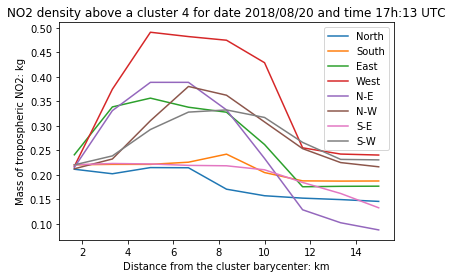

In [77]:
for dir_index in range(len(densities_NO2_1D)):
    density_dir = densities_NO2_1D[dir_index]
    plt.plot(density_dir["upper_bound"]*max_dist_map_in_km/max_dist_map_long_lat,
             density_dir["Values"]*Molar_mass_of_NO2*pixel_surface)
plt.legend(Convention_directions,bbox_to_anchor=(1, 1))
plt.xlabel("Distance from the cluster barycenter: km")
plt.ylabel("Mass of tropospheric NO2: kg")
plt.title('NO2 density above a cluster {} for date {} and time {} UTC'.format(cluster_index,
                                                                              Time_steps[day_index],
                                                                              Hours_NO2_instant[day_index].strftime('%Hh:%M')))
plt.show()

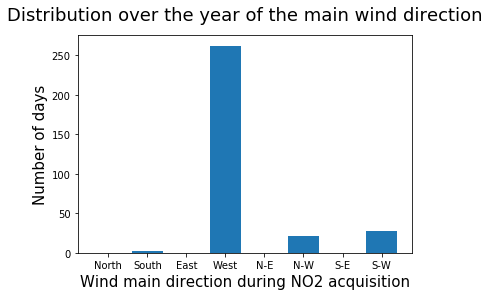

In [78]:
wind_distribution = {direction : 0 for direction in Convention_directions}

for day_index in range(n_t):
    wind_on_location = get_surrounding(Barycenters[cluster_index],
                                       rad,
                                       wind_per_day[day_index],
                                       gfs_coords)
    wind_on_location = wind_on_location.reshape(2,-1)
    wind_on_location = wind_on_location[:,np.linalg.norm(wind_on_location,
                                                         axis = 0,
                                                         ord = 2)>pow(10,-2)]
    mean_wind_on_location = np.mean(wind_on_location, axis = 1)
    dir_index = vect_to_direction(mean_wind_on_location)
    wind_distribution[Convention_directions[dir_index]] += 1
    #print("Wind direction for date {} and time {} UTC : {}".format(Time_steps[day_index],
    #                                                               Hours_NO2_instant[day_index].strftime('%Hh:%M'),
    #                                                               Convention_directions[dir_index]))

plt.bar(wind_distribution.keys(), wind_distribution.values())
plt.title("Distribution over the year of the main wind direction", fontsize=18, pad=15)
plt.xlabel("Wind main direction during NO2 acquisition", fontsize=15)
plt.ylabel("Number of days", fontsize=15)
plt.show()

We can see that the main wind direction above power plants is West, with a huge majority. In the plot above where NO2 density is displayed per discrete direction around a specific cluster, one can notice that the West 1D density is higher and has a specific form : we can see a kind of diffusion.
This impression is formalised just below.

### Description of the next approach

We can notice that the density of tropospheric NO2 evolves in a different way along the wind direction compared to other directions. With functions defined above we have now the opportunity to create a dataframe we will complete with temperature and humidity information.

We will process in the following way:

- For each cluster of power plants and each day in cleaned NO2 data:
    - We will compute mean wind direction in a specific surrounding.
    - We will compute the lineic density of NO2, temperature above ground, wind projection on the $\vec{u}$ direction and relative humidity above ground along each direction $\vec{u}$.
    
- We will fit a model with all this data (one model per cluster) in the discrete direction that corresponds to the principal wind direction: 

$$ NO2_{\vec{u}}(x_{\vec{u}},t) = f(x_{\vec{u}}, \vec{v}(t).\vec{u}, T_{\vec{u}}(x_{\vec{u}},t), H_{\vec{u}}(x_{\vec{u}},t),t)$$, where :

- $\vec{u}$ is the direction that corresponds to the local principal direction of the wind.
- $x_{\vec{u}}$ is the distance from the barycenter of the cluster along direction $\vec{u}$ (m).
- t is the date of the observation : we will keep one per day knowing NO2 acquisition time and GFS one.
- $\vec{v}(t)$ is the spatial mean vector of the wind at time t, close to the barycenter (m/s).
- $ NO2_{\vec{u}}(x_{\vec{u}},t)$ is the average density of tropospheric NO2 along $\vec{u}$ direction at distance $x_{\vec{u}}$ from the barycenter at time t (mol/m²).
- $T_{\vec{u}}(x_{\vec{u}},t)$ is the average temperature above ground along $\vec{u}$ direction at distance $x_{\vec{u}}$ from the barycenter at time t (°C).
- $H_{\vec{u}}(x_{\vec{u}},t)$ is the average relative humidity above ground along $\vec{u}$ direction at distance $x_{\vec{u}}$ from the barycenter at time t (%).
    
In this way, after fitting we will manage to distinguish plant (and maybe urban activities) contributions to natural (background) contributions expressed by temperature and humidity information (as we mentioned above those two factors are considered as the main natural ones of NO2 emissions).

$NB$: This model entails the following assumption (backed by literature articles and numerical simulations such as Liu et al. already cited): when the wind speed is high enough (which is the case in the GFS data, the wind is always greater than 1m/s and in average about 5m/s) the power-plant-related NO2 portion of a 2D field is only a fraction (that we have to estimate) of the tropospheric NO2 located in the eighth of a disc around this specific power plant (or cluster of power plants) that corresponds to the wind direction.

### Practical motivations of the model and process mentioned above

Several remarks may underpin our choice :
    
- Taking NO2 emissions preferentially in the wind direction and in a certain surrounding of plant clusters is a way to select emissions linked to those plants and to exclude other sources.

- 1D fitting is easier than 2D, all the more with a small amount of samples in our dataset (only one year of data, and NO2 data having NAN values in many pictures thus interpolated or excluded).

- Forcing additive model is easier in 1D and it might get better generalization.

### Let's create the dataframe mentioned above

Since wind, temperature and relative humidity information are stored in the same picture and thus have the same coordinates, we can factorize extraction to create the dataframe.

In [79]:
def Create_dataframe(radius_for_surrounding = 15, sources_locations = Barycenters):
    '''Whole function to extract data and build the dataframe described above'''

    Global_dataframe = pd.DataFrame()
    
    for index, date, hour, wind, temperature, humidity in zip(list(range(len(Time_steps))),
                                                              Time_steps,
                                                              Hours_NO2_instant,
                                                              wind_per_day,
                                                              temperature_per_day,
                                                              humidity_per_day):
        #print('Dealing with index '+str(index)+' over '+str(n_t))
        date_hour = datetime.strptime(date+hour.strftime('/%H/%M/%S'),'%Y/%m/%d/%H/%M/%S')
        
        for location_index in range(len(sources_locations)):
            location = sources_locations[location_index]    

        
            #let's have local wind direction
            wind_in_surrounding = get_surrounding(location,
                                                  radius_for_surrounding,
                                                  wind, gfs_coords)
            wind_in_surrounding = wind_in_surrounding.reshape(2,-1)
            wind_in_surrounding = wind_in_surrounding[:,np.linalg.norm(wind_in_surrounding,
                                                                       axis = 0,
                                                                       ord = 2)>pow(10,-2)]
            mean_wind_on_location = np.mean(wind_in_surrounding, axis=1)
            dir_index = vect_to_direction(mean_wind_on_location)
                
            #let's compute lineic functions
            #we extract 8 fields in the same time
            temperature_8_directions = get_8_directions(location,
                                                        radius_for_surrounding,
                                                        temperature,
                                                        gfs_coords)
            humidity_8_directions = get_8_directions(location,
                                                     radius_for_surrounding,
                                                     humidity,
                                                     gfs_coords)
            NO2_8_directions = get_8_directions(location,
                                                radius_for_surrounding,
                                                tropospheric_NO2_per_time[index],
                                                Coords_per_time[index])
                
            #focus on each of the 8 discrete directions
            for discrete_direction in range(len(Convention_directions)):
                shapes = []
                    
                distance_along_direction = np.array(temperature_8_directions[discrete_direction]["upper_bound"])
                shape_distance_along_direction = distance_along_direction.shape[0]
                shapes.append(shape_distance_along_direction)
                
                density_temperature_1D = np.array(temperature_8_directions[discrete_direction]["Values"])
                shape_density_temperature_1D = density_temperature_1D.shape[0]
                shapes.append(shape_density_temperature_1D)
                
                density_humidity_1D = np.array(humidity_8_directions[discrete_direction]["Values"])
                shape_density_humidity_1D = density_humidity_1D.shape[0]
                shapes.append(shape_density_humidity_1D)
                
                density_NO2_1D = np.array(NO2_8_directions[discrete_direction]["Values"])
                shape_density_NO2_1D = density_NO2_1D.shape[0]
                shapes.append(shape_density_NO2_1D)
                
                shapes = np.array(shapes)
                shape_0 = np.array([shape_distance_along_direction]*4)
                if(np.not_equal(shapes, shape_0).any()):
                    #print("Shape issue, continue")
                    continue
                
                #because dataframe asks for same shape arrays input
                length_arrays = distance_along_direction.shape[0]
                projection_local_wind_along_format = np.array([np.dot(mean_wind_on_location,
                                                                      Convention_vectors[discrete_direction])]*length_arrays)
                date_hours_along_format = np.array([date_hour]*length_arrays)
                location_along_format = np.array([location_index]*length_arrays)
                dir_index_along_format = np.array([dir_index]*length_arrays)
                discrete_direction_along_format = np.array([discrete_direction]*length_arrays)
            
                #let's create a dataframe
                temp_dict = {"date" : date_hours_along_format,
                             "cluster_index" : location_along_format,
                             "wind_direction_index" : dir_index_along_format,
                             "discrete_direction" : discrete_direction_along_format,
                             "distance_along_discrete_direction" : distance_along_direction,
                             "wind_projection_along_discrete_direction" : projection_local_wind_along_format,
                             "density_temperature" : density_temperature_1D,
                             "density_relative_humidity" : density_humidity_1D,
                             "density_tropospheric_NO2" : density_NO2_1D}
                temp_columns = ["date",
                                "cluster_index",
                                "wind_direction_index",
                                "discrete_direction",
                                "distance_along_discrete_direction",
                                "wind_projection_along_discrete_direction",
                                "density_temperature",
                                "density_relative_humidity",
                                "density_tropospheric_NO2"]
                temp_df = pd.DataFrame(columns=temp_columns, data=temp_dict)
                Global_dataframe = pd.concat([Global_dataframe, temp_df],
                                             ignore_index=True)          
            
    #we export as csv to avoid extracting several times  
    print('Saving Dataframe ...')
    Global_dataframe.to_csv(path_or_buf='Global_dataframe.csv',
                            index=False)
    return

In [80]:
Create_dataframe()

Saving Dataframe ...


## V -  Fitting : we physically and mathematically define, fit and use a model based on the dataset created in the fourth part of this notebook

Let's extract the dataframe we created and add some columns:

In [81]:
Global_dataframe = pd.read_csv('Global_dataframe.csv') 

In [82]:
#from https://stackoverflow.com/questions/35337299/python-datetime-to-float-with-millisecond-precision
def datetime_to_float(d):
    epoch = datetime.utcfromtimestamp(0)
    total_seconds =  (d - epoch).total_seconds()
    # total_seconds will be in decimals (millisecond precision)
    return total_seconds

def float_to_datetime(fl):
    return datetime.fromtimestamp(fl)

In [83]:
#we add date columns and get floats to process optimization
Global_dataframe['date'] = pd.to_datetime(Global_dataframe['date'], format='%Y-%m-%d %H:%M:%S')
Global_dataframe['date'] = np.array(list(map(datetime_to_float,Global_dataframe['date'])))

In [84]:
#we convert distance in meters:
dist_in_m = 10000
dist_in_lon_lat = 0.0857836897149853
scale_factor = dist_in_m/dist_in_lon_lat

Global_dataframe['distance_along_discrete_direction'] = scale_factor*Global_dataframe['distance_along_discrete_direction']

### A) Theory and mathematical form of the NO2 density

We can assume a certain form for the $f$ function underpinned by physics background, so as to implement and fit additive models:

First, for a 2D physical description of total emissions, we write the following formula for a plant isolated (with no big city or airport or any human source of NO2 around):

$$ NO2(\vec{x},t) = a(t).f_\text{diff}(\| \vec{x}\|,\vec{x} \cdot \vec{v}(t)) + \int_{\vec{x_s}} \ b(H(\vec{x_s},t),T(\vec{x_s},t)).f_\text{diff}(\|\vec{x} - \vec{x_s}\|,(\vec{x}-\vec{x_s}) \cdot \vec{v}(t))\, \text{d}^2\vec{x_s} $$

Where :

- $\vec{x}$ is the 2D vector that represents the position of the point we consider in regards to the barycenter of the specific cluster of power plants.

- $\vec{x_s}$ is a 2D vector that represents the position of any source of NO2 other than the cluster of power plants (natural background or other activity) in regards to the barycenter of the specific cluster of power plants.

- t is the date of the observation : we kept one per day knowing NO2 acquisition time and GFS one.

- $\vec{v}(t)$ is the value of the local wind above the cluster of plants at time t ($m/s$).

- $NO2(\vec{x},t)$ is the average density of tropospheric NO2 at position $\vec{x}$ from the barycenter of the cluster of power plants at time t ($mol/m^2$).

- $a(t)$ is the amount of molecules of NO2 emitted by the cluster of plants we consider at time t during one lifetime of NO2 ($mol$).

- $f_{\text{diff}}(\| \vec{x}\|,\vec{x} \cdot \vec{v}(t))$ is the diffusion function that models the way source at distance $\| \vec{x}\|$ from the point we consider in a wind $\vec{v}(t)$ sees its emitted particles moved over space ($m^{-2}$).

- $H(\vec{x_s},t)$ is the average relative humidity at position $\vec{x_s}$ at time t (%).

- $T(\vec{x_s},t)$ is the average temperature at position $\vec{x_s}$ at time t (°C).

- $b(H(\vec{x_s},t),T(\vec{x_s},t))$ is the density of NO2 sources other than the cluster of plants, depending on temperature and humidity (assumption) ($mol/m^{2}$)

This expression can be thought analogously with heat diffusion in a 2D space and with a specific source highlighted. Though it seems to rigorously model emissions in an additive way, it can not be used as such in a computer model. We will make several approximations to get a practical formula. 

#### How temperature and relative humidity evolve with space ?

In [85]:
stats.pearsonr(Global_dataframe["distance_along_discrete_direction"], Global_dataframe["density_temperature"])

(-0.06757647552925877, 2.8055288209121116e-181)

In [86]:
stats.pearsonr(Global_dataframe["distance_along_discrete_direction"], Global_dataframe["density_relative_humidity"])

(0.029929576847063648, 5.599810058683503e-37)

As the Pearson correlation coefficients between temperature and position and humidity and position show, there is no linear correlation between those variables. In addition, we see small local variations in the 2D pictures at the scale we consider. We will thus assume that $H$ and $T$ do not depend on $\|\vec{x_s}\|$. Therefore, averaging the $f_\text{diff}$ function on space with the integral (having the speed constant over space) leads us to the following expression:

$$ NO2(\vec{x},t) = a(t).f_\text{diff}\big(\| \vec{x}\|,\vec{x} \cdot \vec{v}(t)\big) + B(T(t),H(t))$$

Where we can define new variables:
   - $T(t)$ is the average temperature in the surrounding of the cluster at time t (°C).
   - $H(t)$ is the average relative humidity in the surrounding of the cluster at time t (%).
   - $B$ is the background function that depends on temperature and humidity ($mol/m^2$).

As a first attempt we will suppose that $B$ is affine and $f_\text{diff}$ is a gaussian function distorted by wind.

Indeed, Fick's second law of diffusion https://en.wikipedia.org/wiki/Fick%27s_laws_of_diffusion#Fick's_second_law suggests for $f_\text{diff}$ a gaussian  part. Wind will apply distortion with an exponential function, see https://www.atmos-chem-phys.net/16/5283/2016/acp-16-5283-2016.pdf section 2.2.1.

We focus only in the wind direction above a cluster at time t and we write:

$$f_{\text{diff},\vec{u}}(x,\vec{v}(t).\vec{u}) = \frac{1} {d} \times exp\Bigg(\frac {-x} {\vec{v}(t).\vec{u} \times t_0}\Bigg) \times \frac{1} {\sqrt{2 \pi} \sigma} exp\Bigg(\frac {-x^2} {2 \sigma^2}\Bigg)$$

Where :
   - $\vec{u}$ is the principal direction of the wind above the cluster considered (one among the 8 depicted above).
   - $x$ is the distance from the barycenter of the cluster along direction $\vec{u}$ (m).
   - t is the date of the observation : we will keep one per day knowing NO2 acquisition time and GFS one.
   - $\vec{v}(t)$ is the spatial mean vector of the wind at time t, close to the barycenter (m/s).
   - $exp\Big(\frac {-x} {\vec{v}(t).\vec{u} \times t_0}\Big)$ accounts for the wind distortion and chimical absorbtion compared to Fick's diffusion without wind.
   - $\frac{1} {\sqrt{2 \pi} \sigma} exp\Big(\frac {-x^2} {2 \times \sigma^2}\Big)$ represents the Fick diffusion.
   - $d$ is the known characteristic distance of the slice we consider in the direction orthogonal to the wind direction (m).

We have two free parameters we will have to fit in this expression : $t_0$ linked to NO2 lifetimes as Liu et al. suggest in the article mentioned above, and $\sigma$ which is a characteristic distance for Fick's diffusion.

The whole framework in the wind direction $\vec{u}$ for a specific cluster is thus the following (with notations introduced above):

$$NO2_{\vec{u}}(x,t) = a(t) \times \frac{1} {d} \times exp\Bigg(\frac {-x} {\vec{v}(t).\vec{u} \times t_0}\Bigg) \times \frac{1} {\sqrt{2 \pi} \sigma} exp\Bigg(\frac {-x^2} {2 \sigma^2}\Bigg) + \alpha.T(t) + \beta.H(t) + \gamma$$

We will split our dataset in train and test and try to learn $a(t)$, $t_0$, $\sigma$, $\alpha$, $\beta$ and $\gamma$ parameters. If we manage to fit properly, we will get plant emissions over space and time with the part:

$$\boxed{NO2_{\vec{u},cluster}(x,t) = a(t) \times  \frac{1} {d} \times exp\Bigg(\frac {-x} {\vec{v}(t).\vec{u} \times t_0}\Bigg) \times \frac{1} {\sqrt{2 \pi} \sigma} exp\Bigg(\frac {-x^2} {2 \sigma^2}\Bigg)}$$

In the end, we will get the total emissions of the plant during one lifetime at the time of acquisition of the NO2 picture with:
    $$\boxed{NO2_{cluster}(t) = a(t)}$$
    
We will then need to multiply by the number of NO2 lifetimes per day to deduce daily emissions of the specific cluster, as we did in section III.

### B) Fitting implementation

We will focus on each cluster separately. Once re-centered above its geographical center, we will focus only on the wind direction (the ray that is the most alined with the averaged wind $\vec{v}(t)$ among the 8 possible directions).

The way we want to model $NO2(x,t)$ is quite particular. Indeed it has several constant parameters :
- $t_0$, $\sigma$, $\alpha$, $\beta$ and $\gamma$
- but **it has also a time-dependant parameter $a(t)$** that we particularly want to know ! 


We cannot perform this fitting using traditional methods because $a(t)$ is not reductible to a single scalar. Hence, we will use a trick, hiding $a(t)$ as a dummy variable that is not explicitlely fitted along with the other constant variables. Indeed, for a given set of constant variables $(t_0,\sigma, \alpha, \beta, \gamma)$, we are going to compute for each moment $t$ the value $a(t)$ as the following optimum :

$$ a(t) = \text{argmin}_a \sum_x \Big[\text{model}[a,t_0,\sigma, \alpha, \beta, \gamma]\big(x,t,\vec{v}(t).\vec{u},T(t),H(t)\big)- NO_2(x,t)\Big]^2 $$

In the following model function, $X$ is the vector of variables we consider :
$$ $$
$$X = \Big(x,t,\vec{v}(t).\vec{u},T(t),H(t)\Big)$$
$$$$
We have one vector per sample in the Global_dataframe dataset.

We first define a plot function to display results of the fitting:

In [87]:
#plot function to display fitting results
#source :https://matplotlib.org/3.1.0/gallery/statistics/confidence_ellipse.html
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of x and y

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : ~matplotlib.patches.Patch properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

We define the form of the function *model_func* we want to fit and links between parameters. The function *find_a* does the optimisation process to find $a(t)$ discussed above and stacks it with its corresponding parameters $(t_0,\sigma, \alpha, \beta, \gamma)$ in the dictionnary *params_a_dict*.

In [88]:
#fit per cluster in the wind direction
Convention_directions = np.array(['North', 'South', 'East', 'West', 'N-E', 'N-W', 'S-E', 'S-W'])
Cluster_number = Global_dataframe["cluster_index"].unique()

#define the model function
params_a_dict = {clust_ind : dict() for clust_ind in Cluster_number}

def find_a(X,t0,sigma,alpha,beta,gamma, Y_mean, Y_std, linkers):
    '''For given set of variables and a given time t, find the corresponding
    activity a(t) of the plant, computed as the optimal number that fits :
    N02(x,t) = model(a(t),x,wind,temp,hmdity,t0,sigma,alpha,beta,gamma)
    then the model value N02_emission/std(N02_emission)'''
    
    clust_ind = np.array(linkers['cluster_index'])[0]
    
    # variables that define explicitely the model
    params = np.array([t0,sigma,alpha,beta,gamma])
    
    if X[1] in params_a_dict[clust_ind].keys() and \
    (params == params_a_dict[clust_ind][X[1]][0]).all(): 
        # in case we know a(t) because already computed for other radial distance
        a = params_a_dict[clust_ind][X[1]][1]
        plant_contrib = a*np.exp(-X[0]/(X[2]*t0))*np.exp(-X[0]**2/(2*sigma**2))
        background_contrib = alpha*X[3]+beta*X[4]+gamma
        models_value = plant_contrib+background_contrib-Y_mean/Y_std
        return models_value
    
    else: # otherwise we have to find a(t) by optimizing the model over space
        expected_values = np.array(linkers['density_tropospheric_NO2'][linkers['date']==X[1]])#values of observed NO2
        n_dist = len(expected_values)
        distances = np.reshape(np.array(linkers['distance_along_discrete_direction'][linkers['date']==X[1]]),(1,n_dist))
        f_diffs = np.exp(-distances/(X[2]*t0))*np.exp(-distances**2/(2*sigma**2))#diffusion function defined above
        upper_bound = np.min(expected_values/f_diffs)/Y_std#we know that a(t)*f_diff can not be greater than NO2(x,t)
        n_a = 50
        activity_range = np.reshape(np.linspace(0,upper_bound,n_a),(n_a,1))#where a can be found
        
        expected_values = (expected_values-Y_mean)/Y_std
        expected_values = np.reshape(expected_values,(1,n_dist))#reshape for comparison below
        
        #compute plant contrib and background contrib for each potential a, deduce model value
        potential_plant_contrib = activity_range.dot(np.exp(-distances/(X[2]*t0))*np.exp(-distances**2/(2*sigma**2)))
        background_contrib = alpha*X[3]+beta*X[4]+gamma
        models_value = potential_plant_contrib+background_contrib-Y_mean/Y_std
        
        #select best discrete a to fit expected values with the selected parameters (norm 2 argmin)
        best_index = np.argmin(np.sum((models_value-np.ones((n_a,1)).dot(expected_values))**2,axis=1))
        
        #store the argmin and the corresponding model
        params_a_dict[clust_ind][X[1]] = (params, np.float(activity_range[best_index]))
        model_value = models_value[best_index, np.argmin(abs(distances-X[0]))]
        
        #add physical constraints: plant contribution must be positive and smaller than total NO2
        if potential_plant_contrib[best_index, np.argmin(abs(distances-X[0]))]<0:
            print('Warning, negative plant contribution : ',
                   potential_plant_contrib[best_index, np.argmin(abs(distances-X[0]))]<0)
            
        if 0.99*potential_plant_contrib[best_index, np.argmin(abs(distances-X[0]))]>\
        np.float(linkers['density_tropospheric_NO2'][np.logical_and(linkers['date']==X[1],
                                                     linkers['distance_along_discrete_direction']==X[0])])/Y_std:
            print('Warning, over plant contribution : ',
                  potential_plant_contrib[best_index, np.argmin(abs(distances-X[0]))],
                  np.float(linkers['density_tropospheric_NO2'][np.logical_and(linkers['date']==X[1],
                                                               linkers['distance_along_discrete_direction']==X[0])])/Y_std)
        return model_value

def model_func(Xs,t0,sigma,alpha,beta,gamma, Y_mean, Y_std, linkers):
    '''Returns estimation of N02_emission/std(N02_emission)'''
    model_values = np.array(list(map(lambda X : find_a(X,t0,sigma,alpha,beta,gamma,
                                                       Y_mean,Y_std,linkers),Xs)))
    return model_values

def model_func_wrapper(Y_mean,Y_std,linkers):
    return lambda X,t0,sigma,alpha,beta,gamma : model_func(X,t0,sigma,alpha,beta,gamma,
                                                           Y_mean,Y_std,linkers)

Hence, finding the optimal solution for $(t_0,\sigma, \alpha, \beta, \gamma)$ using **Scipy** module *curve_fit* leads us to the corresponding $a(t)$ stacked in the dictionnary *plants_activity* and the estimated N02 repartition due to the plant in the file *Plant_emissions_from_physical_fit* : 

The initial R^2 coef is : -1.4552413505010038
Start fitting on 1294 samples for cluster : 0
Fitting model done
Optimal parameters :  [ 1.99995727e+05  4.46610647e+04 -3.72026828e-02 -7.00594338e-03
  2.47869405e+00]
The explained variance is : 0.5980388546948662
The mean squared error is : 0.2499177522279733
The R^2 coef is : 0.5976716317382721


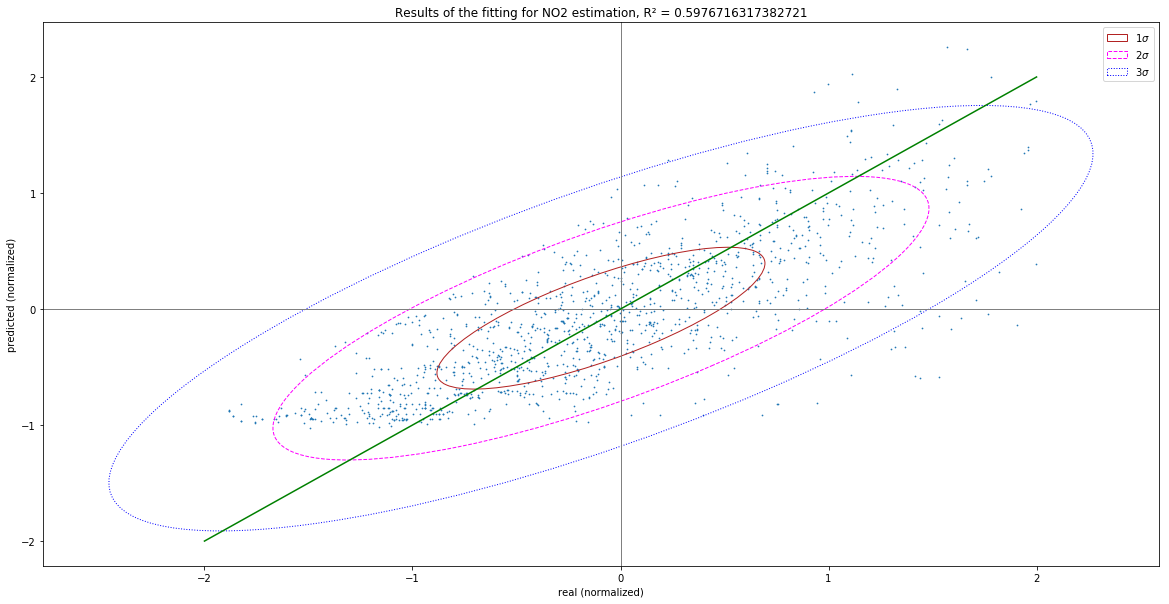

Dataframe completed
The initial R^2 coef is : -0.9130675468569454
Start fitting on 1180 samples for cluster : 1
Fitting model done
Optimal parameters :  [ 1.79760227e+05  4.60065336e+04 -4.35908311e-02 -2.89774983e-03
  2.30590006e+00]
The explained variance is : 0.5699027265779276
The mean squared error is : 0.29523671502787
The R^2 coef is : 0.5697485052245697


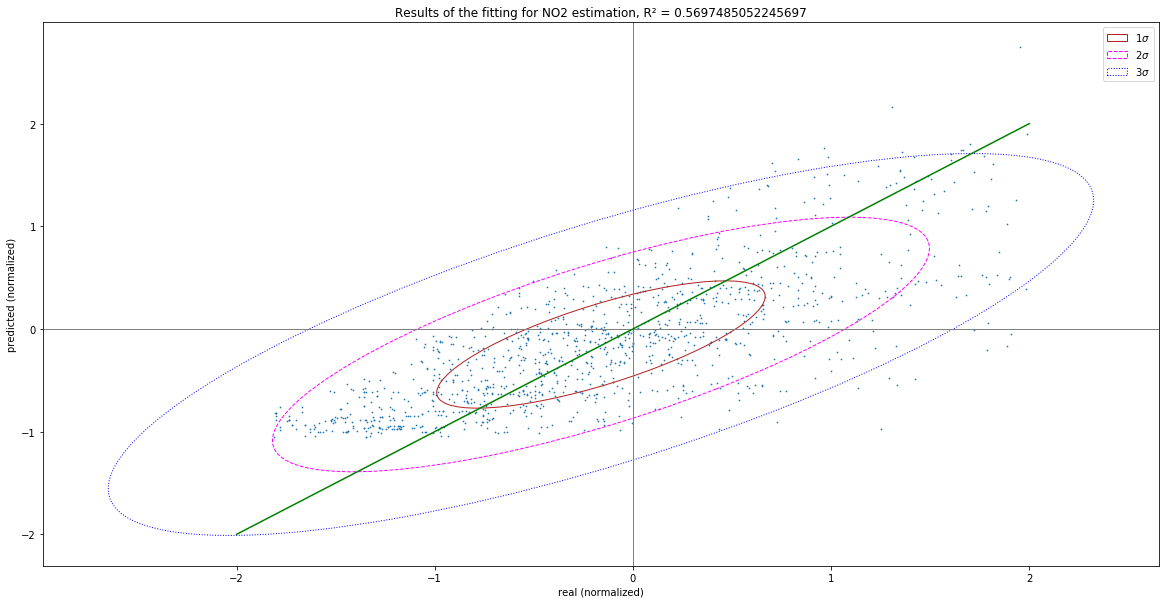

Dataframe completed
The initial R^2 coef is : -1.5867269462175715
Start fitting on 1303 samples for cluster : 2
Fitting model done
Optimal parameters :  [ 1.99999918e+05  2.87096834e+04 -2.34240148e-02 -7.57129244e-03
  2.24324925e+00]
The explained variance is : 0.6100002245804197
The mean squared error is : 0.3012887791987526
The R^2 coef is : 0.6099682283212655


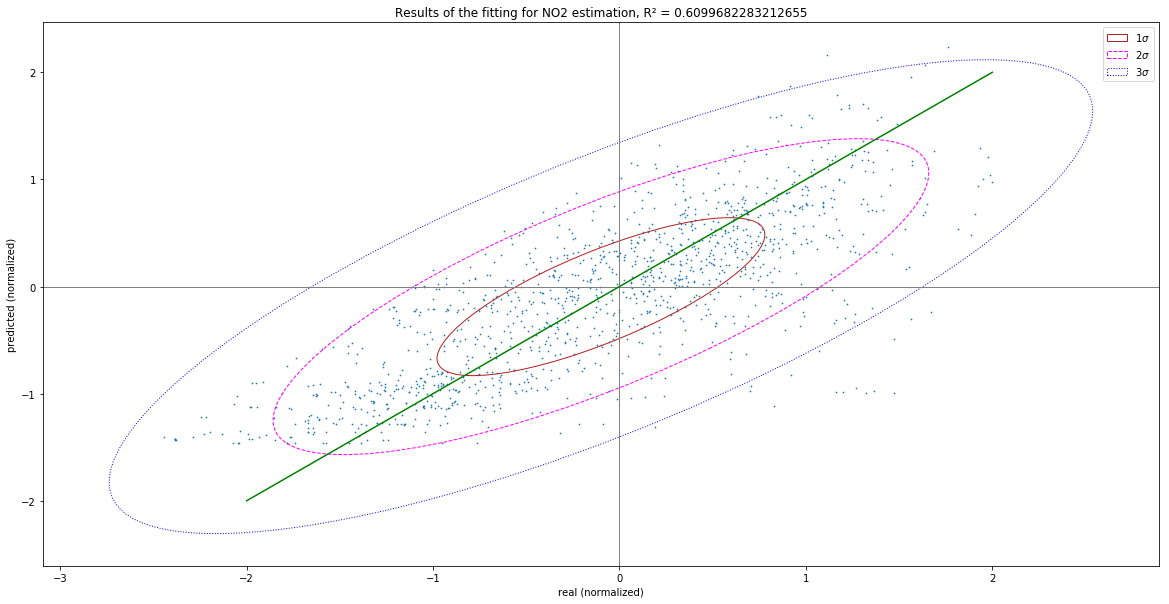

Dataframe completed
The initial R^2 coef is : -1.2575415344183125
Start fitting on 1337 samples for cluster : 3
Fitting model done
Optimal parameters :  [ 1.61999926e+05  2.77628211e+04 -1.89129769e-02  3.28162251e-03
  1.35546734e+00]
The explained variance is : 0.7619714303463674
The mean squared error is : 0.18728406287629676
The R^2 coef is : 0.7619656667010157


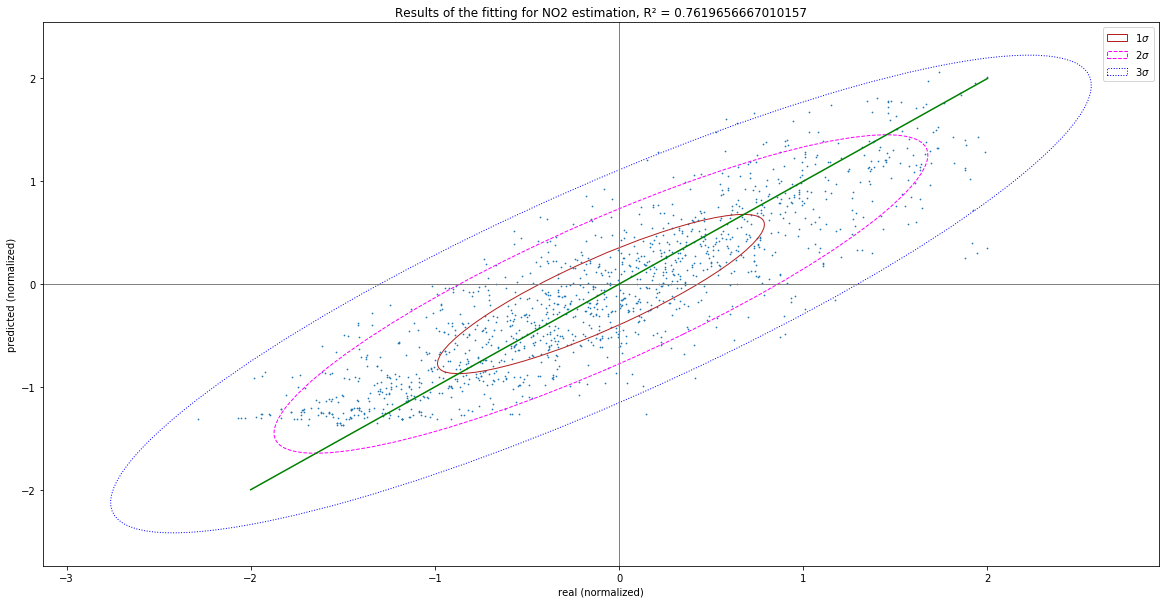

Dataframe completed
The initial R^2 coef is : -1.5652622132819332
Start fitting on 1326 samples for cluster : 4
Fitting model done
Optimal parameters :  [1.99998307e+05 4.96889004e+04 8.56741236e-03 7.46179017e-03
 7.59597301e-02]
The explained variance is : 0.7528493108305373
The mean squared error is : 0.14639611618498746
The R^2 coef is : 0.7528480342704835


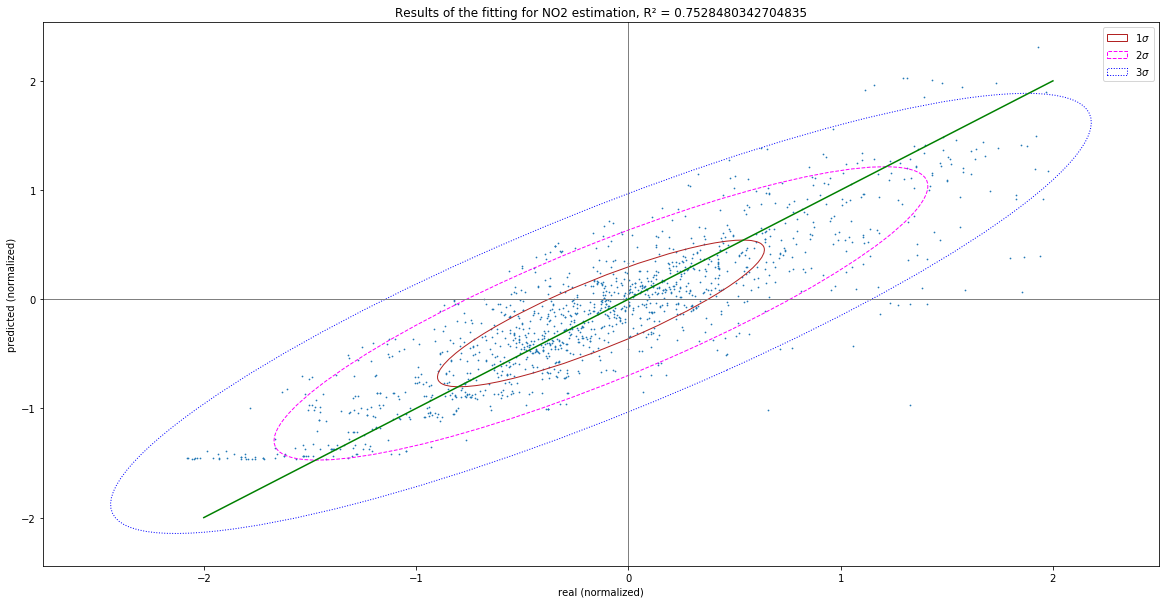

Dataframe completed
The initial R^2 coef is : -0.7183484415098311
Start fitting on 1139 samples for cluster : 5
Fitting model done
Optimal parameters :  [ 1.98915125e+05  2.52143030e+04 -2.74072268e-03  1.74170706e-03
  8.37644049e-01]
The explained variance is : 0.5719261218302882
The mean squared error is : 0.2972881075536006
The R^2 coef is : 0.5718192931079146


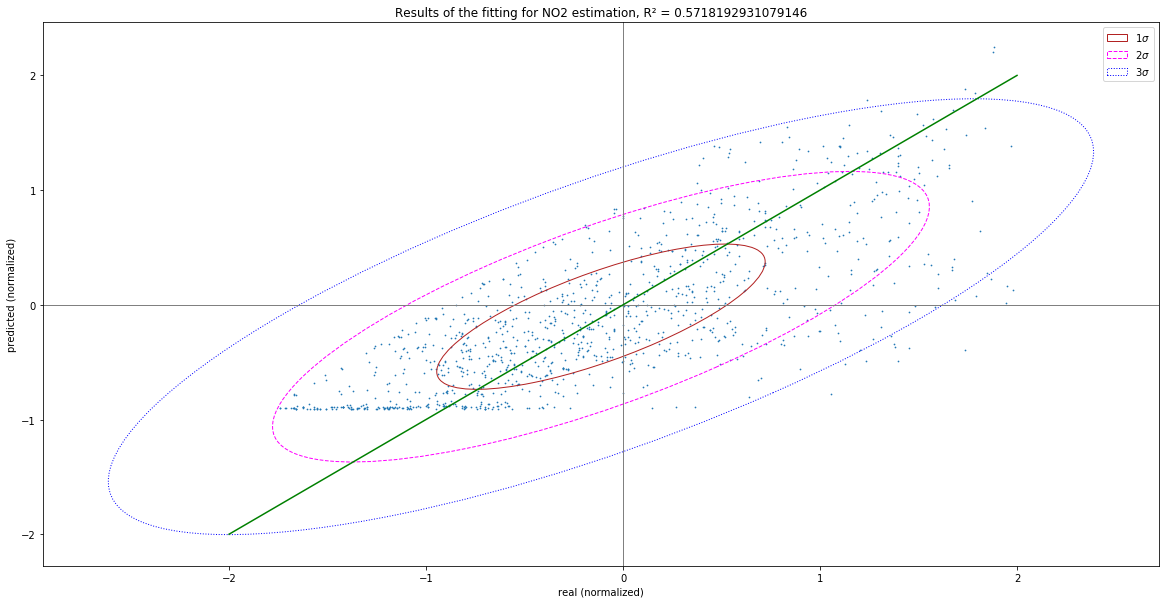

Dataframe completed
The initial R^2 coef is : -1.1030382695196939
Start fitting on 1208 samples for cluster : 6
Fitting model done
Optimal parameters :  [ 1.96680227e+05  4.89197238e+04  3.89172326e-02 -3.02458448e-03
  1.81553683e-01]
The explained variance is : 0.6146679463450115
The mean squared error is : 0.29517879871717956
The R^2 coef is : 0.6146665656164403


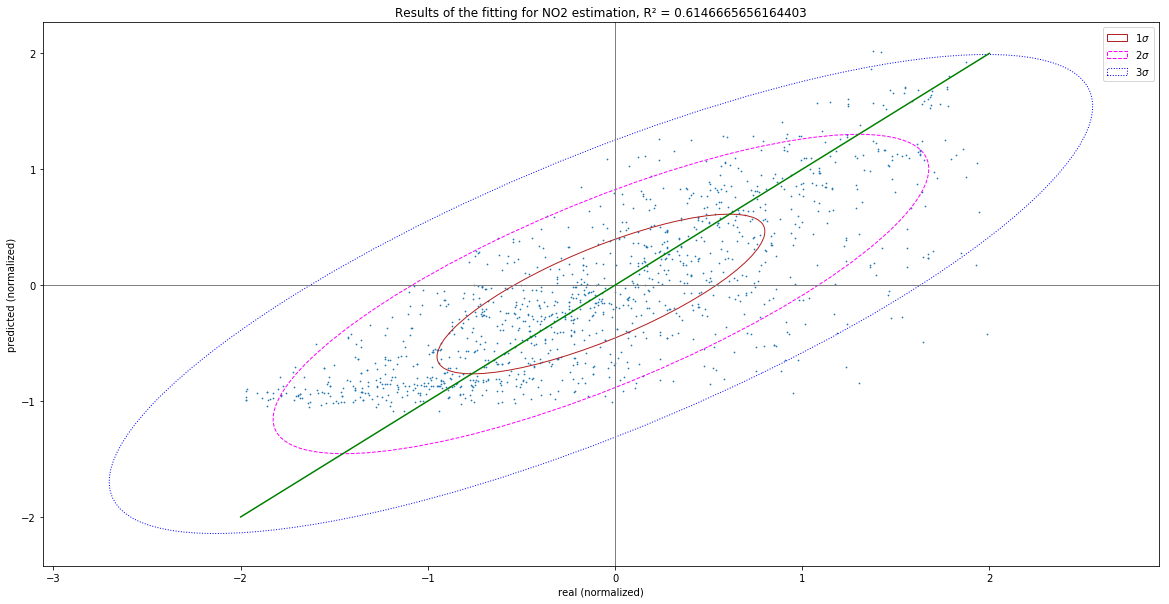

Dataframe completed
The initial R^2 coef is : -1.0940778587136322
Start fitting on 1228 samples for cluster : 7
Fitting model done
Optimal parameters :  [ 2.00000000e+05  4.99999999e+04  4.49215153e-02 -3.01791197e-03
  4.19354538e-02]
The explained variance is : 0.6184700185014931
The mean squared error is : 0.2888801750047631
The R^2 coef is : 0.6183723793499429


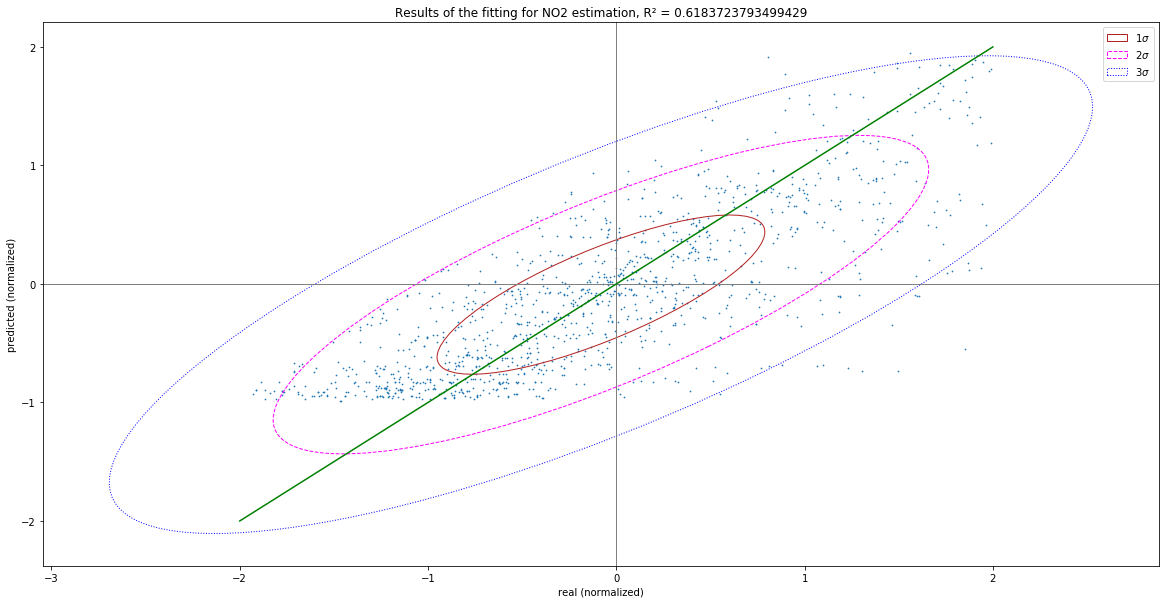

Dataframe completed
The initial R^2 coef is : -1.0933752627807451
Start fitting on 1233 samples for cluster : 8
Fitting model done
Optimal parameters :  [ 2.00000000e+05  5.00000000e+04 -2.05476967e-03 -7.31846553e-03
  1.51067927e+00]
The explained variance is : 0.6202179532201648
The mean squared error is : 0.2834831333256415
The R^2 coef is : 0.6199065163732844


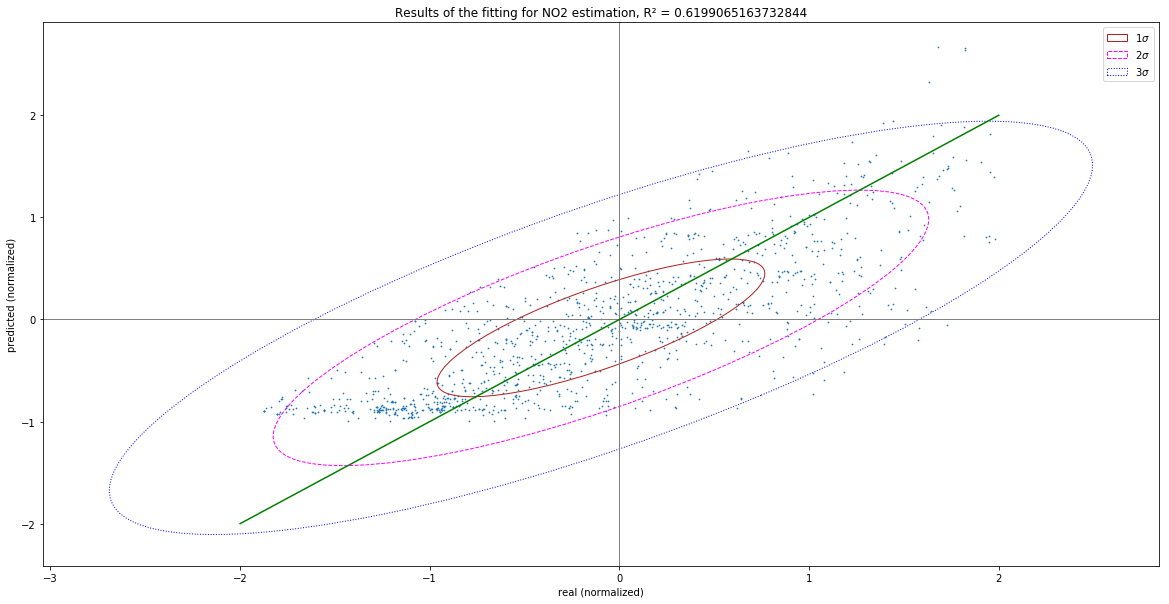

Dataframe completed


In [89]:
Plant_emissions_from_physical_fit = pd.DataFrame()
p_inis = {clust_ind : [2e4, 8e3, 0, 0, 0] for clust_ind in Cluster_number}

#variables to explain NO2
Variable_names = ['distance_along_discrete_direction','date',
                  'wind_projection_along_discrete_direction', 
                  'density_temperature','density_relative_humidity']

plants_activity = {clust_ind : dict() for clust_ind in params_a_dict.keys()}

for clust_ind in Cluster_number:   #one model per cluster

    local_index = np.logical_and(Global_dataframe["cluster_index"] == clust_ind,
                                 Global_dataframe["discrete_direction"] == Global_dataframe["wind_direction_index"])
    X = np.array(Global_dataframe[Variable_names][local_index])
    
    #NO2 observation
    y = np.array(Global_dataframe['density_tropospheric_NO2'])[local_index]
    linkers = Global_dataframe[['density_tropospheric_NO2', 'date',
                                'distance_along_discrete_direction',
                                'cluster_index']][local_index]

    #normalize 
    y_mean = np.mean(y)  
    y_std = np.std(y) 
    y = (y-y_mean)/y_std 

    #exclude outliers
    y_c = y[y<2]
    X_c = X[y<2,:]

    #split train-test
    X_train, X_test, y_train, y_test = train_test_split(X_c, y_c,
                                                        test_size=0.5,
                                                        random_state=42)

    #see results for p_ini
    [t0_ini,sigma_ini,alpha_ini,beta_ini,gamma_ini] = p_inis[clust_ind]
    y_test_ini = model_func_wrapper(y_mean, y_std, linkers)(X_test,t0_ini,sigma_ini,
                                                            alpha_ini,beta_ini,gamma_ini)
    print('The initial R^2 coef is : {}'.format(r2_score(y_test,y_test_ini)))
    
    #fit model
    print('Start fitting on {} samples for cluster : {}'.format(X_train.shape[0], clust_ind))
    
    popt, pcov = curve_fit(model_func_wrapper(y_mean, y_std, linkers),
                           xdata=X_train, ydata=y_train, p0=p_inis[clust_ind], 
                           bounds=([5e3,2e3,-np.inf,-np.inf,-np.inf],
                                   [2e5,5e4, np.inf, np.inf, np.inf]))
    print("Fitting model done")

    [t0_opt,sigma_opt,alpha_opt,beta_opt,gamma_opt] = popt
    print('Optimal parameters : ', popt)

    #predict on test
    y_hat_model = model_func_wrapper(y_mean, y_std, linkers)(X_test,t0_opt,sigma_opt,
                                                             alpha_opt,beta_opt,gamma_opt)

    #evaluate predictions
    print('The explained variance is : {}'.format(explained_variance_score(y_test,y_hat_model)))
    print('The mean squared error is : {}'.format(mean_squared_error(y_test, y_hat_model)))
    print('The R^2 coef is : {}'.format(r2_score(y_test,y_hat_model)))

    #plot for visual evaluation
    fig, ax = plt.subplots(1, 1, figsize=(20,10))

    ax.scatter(y_test,y_hat_model, s=0.5)
    ax.axvline(c='grey', lw=1)
    ax.axhline(c='grey', lw=1)
    confidence_ellipse(y_test,y_hat_model, ax, n_std=1,
    label=r'$1\sigma$', edgecolor='firebrick')
    confidence_ellipse(y_test,y_hat_model, ax, n_std=2,
    label=r'$2\sigma$', edgecolor='fuchsia', linestyle='--')
    confidence_ellipse(y_test,y_hat_model, ax, n_std=3,
    label=r'$3\sigma$', edgecolor='blue', linestyle=':')
    ax.plot(np.arange(-2,3), np.arange(-2,3), color = 'green')
    ax.set_xlabel("real (normalized)")
    ax.set_ylabel("predicted (normalized)")
    ax.legend()
    ax.set_title("Results of the fitting for NO2 estimation, R² = {}".format(r2_score(y_test,y_hat_model)))
    plt.show()
                       
    cluster_ind_df = np.array(Global_dataframe["cluster_index"][local_index])
    dates = np.array(list(map(float_to_datetime,X[:,1])))
    nature_emissions = y_std*(alpha_opt*X[:,3] + beta_opt*X[:,4] + gamma_opt)  
    plant_emissions = y*y_std + y_mean - nature_emissions   
    temp_dict = {'cluster_index' : cluster_ind_df,
                 'date' : dates,
                 'distance_along_discrete_direction' : X[:,0],
                 'Cluster_related_NO2_Emission' : plant_emissions,
                 'NO2_total' : y*y_std+y_mean}
    
    temp_dataframe = pd.DataFrame(temp_dict)
    Plant_emissions_from_physical_fit = pd.concat([Plant_emissions_from_physical_fit,
                                                   temp_dataframe], ignore_index=True)
    print("Dataframe completed")
    
    plants_activity[clust_ind] = {t : params_a[1] 
                                  for t, params_a in params_a_dict[clust_ind].items()
                                  if (params_a[0]==popt).all()}


In [90]:
plants_activity = {clust_ind : {float_to_datetime(t) : a
                                for t, a in activity.items()}
                   for clust_ind, activity in plants_activity.items()}    
    
print('Saving the estimated plant NO2 emission...')
Plant_emissions_from_physical_fit.to_csv('Plant_emissions_from_physical_fit.csv')

Saving the estimated plant NO2 emission...


## VI- Final results and critics

Now that we have estimated plants-related emissions in the wind direction for every day accessible after NO2 preprocessing and per cluster we are going to compute and display average, montly and marginal emission factors.

### A) Results and answer to the competition

In [91]:
Cluster_inds = Plant_emissions_from_physical_fit['cluster_index'].unique()

In [92]:
def surface(dist_from_cluster_barycenter):
    '''computes the surface represented by a point over a 1D circle split in 8 parts'''
    # distance between two points on a line = 1667 m
    dr = Plant_emissions_from_physical_fit['distance_along_discrete_direction'][0]  
    return(2*np.pi*dist_from_cluster_barycenter*dr/8)

In [93]:
surfaces = np.array(list(map(surface, Plant_emissions_from_physical_fit['distance_along_discrete_direction'])))
Plant_emissions_from_physical_fit['Cluster_related_NO2_Emission_mol'] = surfaces*Plant_emissions_from_physical_fit['Cluster_related_NO2_Emission']

In [94]:
def extract_NO2_related_per_day(str_date, clust_ind):
    '''Computes the estimated instantaneous NO2 emission (mol)
    for a given cluster in a given day'''
    date = datetime.strptime(str_date, '%Y/%m/%d').strftime('%Y-%m-%d')
    local_index = np.logical_and(Plant_emissions_from_physical_fit['cluster_index']==clust_ind,
                                 np.array(list(map(lambda x : x.strftime('%Y-%m-%d'),Plant_emissions_from_physical_fit['date'])))==date)
    return sum(Plant_emissions_from_physical_fit['Cluster_related_NO2_Emission_mol'][local_index])

def extract_NO2_related(clust_ind):
    '''Listing the NO2 emissions over the days for a given cluster'''
    return np.array(list(map(lambda str_date : extract_NO2_related_per_day(str_date, clust_ind),
                             Time_steps)))

In [95]:
print('Deducing NO2 evolution over time per cluster')
NO2_related_per_cluster = {clust_ind : extract_NO2_related(clust_ind)
                           for clust_ind in Cluster_inds}

Deducing NO2 evolution over time per cluster


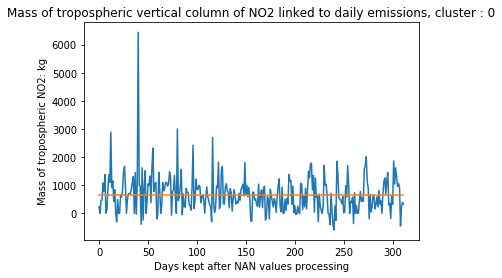

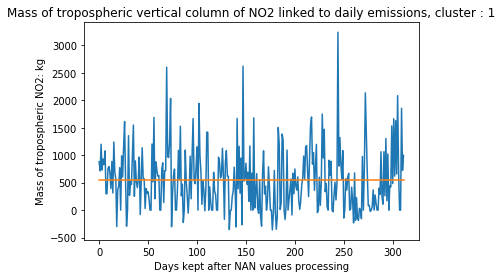

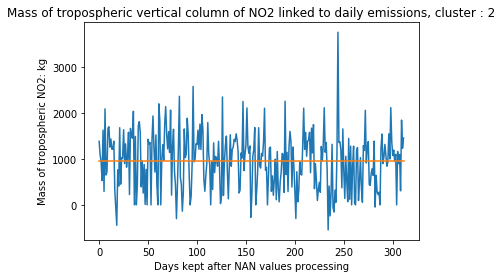

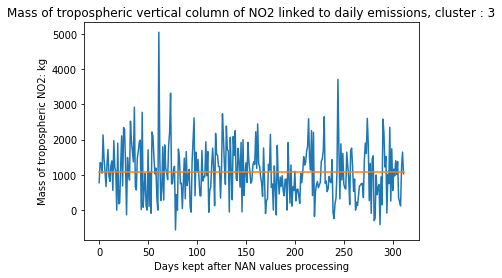

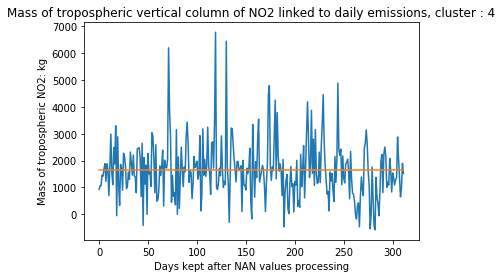

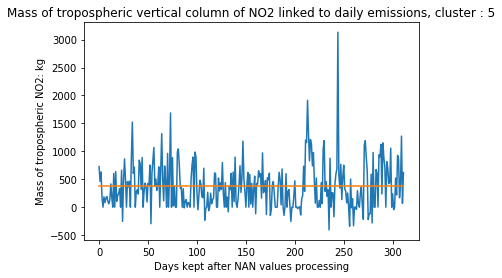

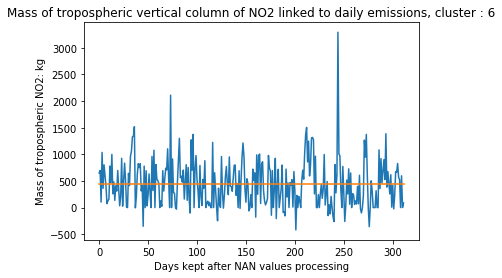

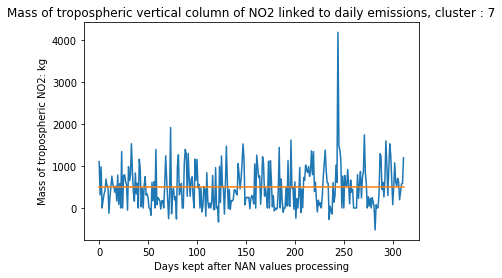

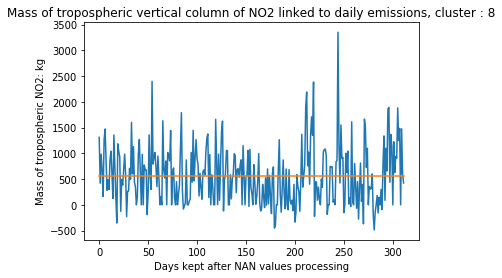

In [96]:
#evolution over time per cluster
Mean_per_cluster = []
Dataframe_emissions = pd.DataFrame()
Dataframe_emissions["Dates"] = Time_steps
Dataframe_emissions["Months"] = pd.DatetimeIndex(Dataframe_emissions['Dates']).month

for clust_ind in Cluster_inds:
    Dataframe_emissions["Emission cluster {}".format(clust_ind)] = NO2_related_per_cluster[clust_ind]
    mean_on_kept_period = Instant_to_day*Molar_mass_of_NO2*np.mean(NO2_related_per_cluster[clust_ind])##mean of daily NO2 mass close to the plant
    Mean_per_cluster.append(mean_on_kept_period)
    plt.plot(Instant_to_day*Molar_mass_of_NO2*NO2_related_per_cluster[clust_ind])
    plt.plot(mean_on_kept_period*np.ones(np.shape(NO2_related_per_cluster[clust_ind])))
    plt.xlabel("Days kept after NAN values processing")
    plt.ylabel("Mass of tropospheric NO2: kg")
    plt.title("Mass of tropospheric vertical column of NO2 linked to daily emissions, cluster : {}".format(clust_ind))
    plt.show()
    
Mean_per_cluster = np.array(Mean_per_cluster)

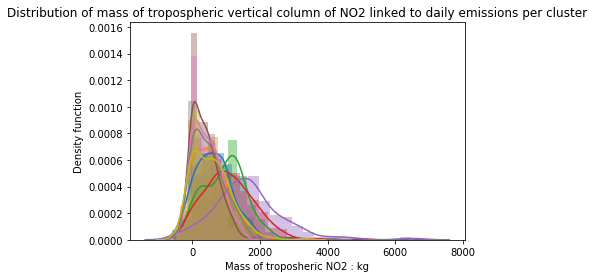

In [97]:
#distribution per cluster
for clust_ind in Plant_emissions_from_physical_fit["cluster_index"].unique():
    sns.distplot(Instant_to_day*Molar_mass_of_NO2*NO2_related_per_cluster[clust_ind])
    plt.xlabel("Mass of troposheric NO2 : kg")
    plt.ylabel("Density function")

plt.title("Distribution of mass of tropospheric vertical column of NO2 linked to daily emissions per cluster")
plt.show()

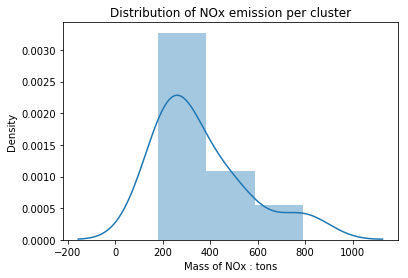

Annual total production per cluster = [ 1550.00322157  9397.90273467  1382.48503748   295.90970594
  9076.5091782    295.90970594   295.90970594    33.51478879
 11074.85088593] GWh


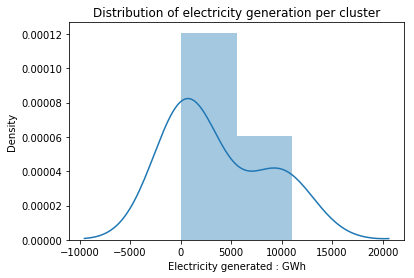

Mean per cluster  = 1203.1978 NOx kg/GWh
Documented values are between 100 (300 in the introduction table) and 1000 (4000 in the same table) kg/GWh


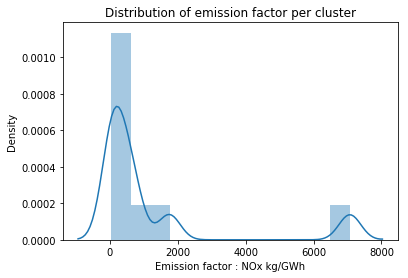

In [98]:
#emissions
first_approx_emission_per_clust = 365*NO2_to_NOx*Mean_per_cluster
sns.distplot(first_approx_emission_per_clust/1000)
plt.title("Distribution of NOx emission per cluster")
plt.xlabel("Mass of NOx : tons")
plt.ylabel("Density")
plt.show()

#electricity generation
generation_per_clust = []
for cluster in Clusters:
    generation_inside_clust = np.array(power_plants["estimated_generation_gwh"][cluster])
    generation_per_clust.append(np.sum(generation_inside_clust))    
generation_per_clust = np.array(generation_per_clust)
print("Annual total production per cluster = {} GWh".format(generation_per_clust))

sns.distplot(generation_per_clust)
plt.title("Distribution of electricity generation per cluster")
plt.xlabel("Electricity generated : GWh")
plt.ylabel("Density")
plt.show()

#emission factor
first_approx_emission_factor_global = first_approx_emission_per_clust/generation_per_clust
#print("Mean NOx emission factor over one year per cluster : = {} NOx kg/GWh".format(first_approx_emission_factor_global))
print("Mean per cluster  = {:.4f} NOx kg/GWh".format(np.mean(first_approx_emission_factor_global)))
print("Documented values are between 100 (300 in the introduction table) and 1000 (4000 in the same table) kg/GWh")
#see for other values : https://books.google.fr/books?id=2L-OIrTBiRMC&pg=PA176&lpg=PA176&dq=NO2x+kg/GWh&source=bl&ots=HpOZw0yPip&sig=ACfU3U3i0w4Ya5ex2vfwOwjNMk27JiG7qg&hl=fr&sa=X&ved=2ahUKEwjws4H_vOPnAhVoDWMBHds2BdAQ6AEwAHoECAcQAQ#v=onepage&q=NO2x%20kg%2FGWh&f=false

sns.distplot(first_approx_emission_factor_global)
plt.title("Distribution of emission factor per cluster")
plt.xlabel("Emission factor : NOx kg/GWh")
plt.ylabel("Density")
plt.show()

#### First answer : average emission factor for the year we consider:

In [99]:
sum_generation = power_plants["estimated_generation_gwh"].sum()
print("Mean emission factor for electricity generation in Puerto Rico = {:.4f} NOx kg/GWh".format(first_approx_emission_per_clust.sum()/sum_generation))

Mean emission factor for electricity generation in Puerto Rico = 96.3761 NOx kg/GWh


#### Additional answer : monthly average emission factors for clusters having all power plants with month data on emission 

After browsing power-plants dataset, the only clusters that have all their plants with monthly values for July 2018 to December 2018 are the clusters with plant 16 (cluster 0) alone and plant 23 alone (cluster 2). We have no data for 2019 and for other clusters. We believed extrapolating data from other years or from one plant to another is hazardous. 
After going into details for those two particular power plants, we discovered some inconsistent data and had no time to find other data sources. We won't display any result for this section because of this inconsistency.

### B) Comments and perspectives

After GPPD correction, NO2 interpolation, data preprocessing and fitting, we managed to get average emission factors for different time slices and marginal emission factors of electricity generated for a sub-national region, using remote sensing data and techniques. 

One can notice that the approach is $\textbf{generic}$. Indeed, we did not take into account any external dataset specific to Puerto Rico (except the GPPD update for energy generation). Nonetheless, since we added many constraints from physics (which are by essence and assumption universal) in a general mathematical formulation (not inherent in Puerto Rico) we could understandably $\textbf{distinguish power-plants-related emissions in a way that could be extended to other regions}$.

The crux of the matter was to $\textbf{consider the amplitude of the distribution of plant emissions a(t) as a function of time and not as a constant}$ so as to compute a relevant evolution over time that depends on the power plants activity evolution over time and not only on the weather conditions evolution over time. We believe this added difficulties to fit but made more sense to understand NO2 evolution over space and time.

To apply this framework to another location, one might think about $\textbf{the way clusters of power-plants are defined}$.
Indeed, this step was crucial and depended a lot on the characteristic distances that can be crossed by NO2 molecules in troposphere before they disapppear.
Besides, though the specific geography of the island did not have a crucial role in our analysis, a sub-national region with a lot of urban areas and airports might need some model updates. Indeed, the distribution of sources we distinguished from the clusters of power-plants were supposed to be smooth over space. This is one limitation entailed by the assumptions we made on the form of the distribution of the density of NO2.  A sum of external located sources could be considered as a new term in the sum of sources, though it would suppose additional complexity and difficulties to train.

One additional limitation of our submission was the $\textbf{conbined effect of the space resolution and of the spatial boundaries}$ on the fit of the model. We could not extract a lot of spatial information for power-plants that were close to the limits of the domain we considered. Thanks to small characteristic distances inherent in NO2 diffusion, we could extract a valuable information anyway. Pushing the boundaries of our dataset could be a way to improve results.

Extra datasets could also be a boon on understanding emission factors. For instance, $\textbf{airports and cities activities}$ could be taken into account in a similar way we modeled power-plant activity, although model complexity would increase and physics understanding would be less clear. A compromise between the variety of variables we consider and their degree of freedom in a model has to be taken.